In [73]:
#deps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

Pops: Do demos at a higher level lead to goals more than demos at a lower level

In [74]:
# read the data
raw_data = pd.read_csv('data/mncs-players.csv')
data = pd.read_csv('data/mncs-players.csv')

player_id_map = raw_data[['player_id', 'player_name']].copy().drop_duplicates(subset='player_id')
def get_player_name_by_id(player_id):
    return player_id_map.loc[player_id_map['player_id'] == player_id, 'player_name'].values[0]

# immediately drop problematic data (such as forfeits or data that is clearly incorrect)
data = data.dropna(subset=['team_id', 'map_name', 'team_color', 'opponent_team_color'])

C:\Users\Corbin\AppData\Local\Temp\ipykernel_2420\2682817120.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data/mncs-players.csv')
C:\Users\Corbin\AppData\Local\Temp\ipykernel_2420\2682817120.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/mncs-players.csv')


In [75]:
# find out where data is missing
missing_data = data.isnull().sum()
print(missing_data[missing_data > 0])

game_id_overtime_game      28074
match_id_win               17586
game_id_win                17586
game_id_win_total          17586
game_id_forfeit_win        35172
overtime_seconds_played    28074
ms_most_forward                1
is_sub_for_team            31052
dtype: int64


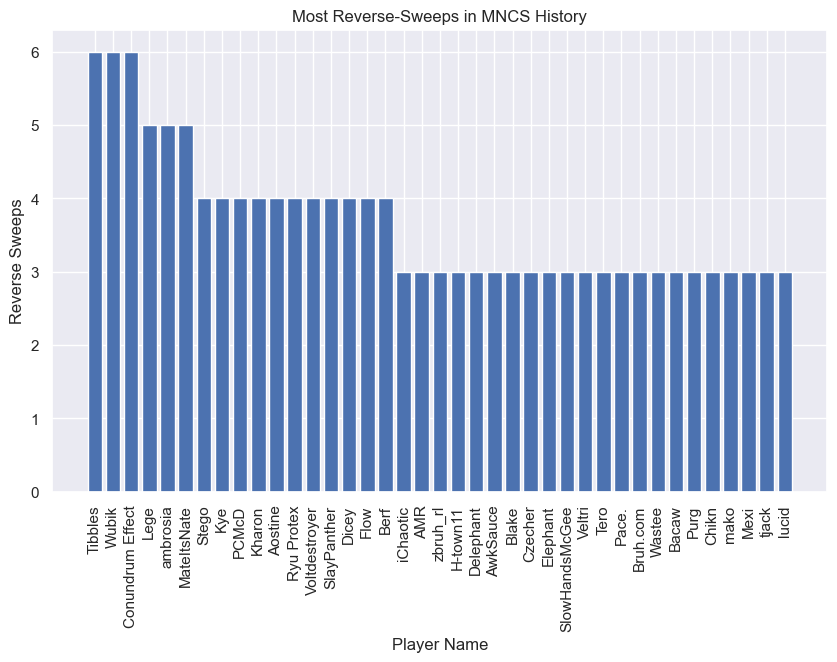

In [76]:
# Filter games 3, 4, 5
filtered_df = data[data['game_number'].isin([3, 4, 5])]

# Group by player_id and match_id, then sum 'win' field
grouped_df = filtered_df.groupby(['player_id', 'match_id'])['wins'].sum()

# Check where sum equals to 3
wins_df = grouped_df[grouped_df == 3]

# Group by player_id and count number of distinct matches
player_wins = wins_df.reset_index().groupby('player_id')['match_id'].count()

# Reset index and rename columns
player_wins_df = player_wins.reset_index().rename(columns={'match_id': 'win_count'})

player_wins_df = player_wins_df[player_wins_df['win_count'] > 2]

player_wins_df = player_id_map.merge(player_wins_df, on='player_id', how='inner')

player_wins_df = player_wins_df.sort_values(by='win_count', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(player_wins_df['player_name'], player_wins_df['win_count'])
plt.xlabel('Player Name')
plt.ylabel('Reverse Sweeps')
plt.title('Most Reverse-Sweeps in MNCS History')
plt.xticks(rotation='vertical') # Rotate x-axis labels
plt.show()

In [64]:
# null handling
true_false_cols = ['is_sub_for_team', 'game_id_overtime_game', 'overtime_seconds_played',
                   'match_id_win', 'game_id_win']
for c in true_false_cols:
    if c in data.columns:
        data[c] = data[c].notnull()
data['overtime_seconds_played'] = data['overtime_seconds_played'].fillna(0)

data = data[data['overtime_seconds_played'] > 0]

# drop useless columns
useless_columns = ['league_name', 'map_name', 'game_id_total',
                   'team_name', 'opponent_team_name','game_id_forfeit_win',
                   'game_id_win_total', 'season_id', 'match_type', 'epoch_processed',
                   'week', 'game_id_win', 'games_played', 'match_id', 'overtime_seconds_played',
                   'game_id_overtime_game', 'goals_against', 'goals_against']
for c in useless_columns:
    if c in data.columns:
        data = data.drop(c, axis=1)

In [65]:
# days from Jan 1, 2019, when the league started
# Convert the date column to datetime and make it tz-naive
data['game_date'] = pd.to_datetime(data['game_date']).dt.tz_convert(None)

# Define the date to subtract from
date_to_subtract = pd.to_datetime('2019-01-01')

# Calculate the number of days difference and assign to the date column
data['game_date'] = (data['game_date'] - date_to_subtract).dt.days

In [66]:
# Check for null values
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

print("Property | isnull() | null-like")
for c in data.columns:
    string_null = np.array([x in null_like for x in data[c]])
    null_sum = string_null.sum()
    if null_sum > 0:
        print(c, null_sum)

Property | isnull() | null-like


In [67]:
print('sum', data.isna().sum().sum())

sum 0


In [68]:
data = data.dropna()

In [69]:
object_columns = data.dtypes[data.dtypes == 'object'].index
print(object_columns)
for column in object_columns:
    print(f"{column}:\n{data[column].head()}\n")

Index(['league_id', 'game_id', 'player_id', 'player_name', 'player_platform',
       'player_platform_id', 'team_id', 'opponent_team_id', 'team_color',
       'opponent_team_color'],
      dtype='object')
league_id:
33    600c92f9f87c0c000826a31f
34    600c92f9f87c0c000826a31f
35    600c92f9f87c0c000826a31f
36    600c92f9f87c0c000826a31f
37    600c92f9f87c0c000826a31f
Name: league_id, dtype: object

game_id:
33    64262c1784b7f100088aa845
34    64262c1784b7f100088aa845
35    64262c1784b7f100088aa845
36    64262c1784b7f100088aa846
37    64262c1784b7f100088aa846
Name: game_id, dtype: object

player_id:
33    5f2c5d31bb182500085b6e0d
34    600c9b08eedc0d00082114a3
35    600c9a5b2c38930008d9cbfc
36    5f2c5d31bb182500085b6e0d
37    600c9b08eedc0d00082114a3
Name: player_id, dtype: object

player_name:
33       Vespid
34    dinger022
35        Jackz
36       Vespid
37    dinger022
Name: player_name, dtype: object

player_platform:
33    steam
34    steam
35     epic
36    steam
37    steam
N

In [70]:
# print out the remaining columns
print('number of games', len(data.index))
for c in data.columns:
    print(c)

number of games 7098
league_id
season_name
game_id
game_date
game_number
match_id_win
player_id
player_name
player_platform
player_platform_id
team_id
opponent_team_id
team_color
opponent_team_color
mvps
wins
ms_played
shots
shots_against
goals
saves
assists
score
amount_collected
amount_stolen
amount_collected_big
amount_stolen_big
amount_collected_small
amount_stolen_small
count_collected_big
count_stolen_big
count_collected_small
count_stolen_small
amount_overfill
amount_overfill_stolen
amount_used_while_supersonic
ms_zero_boost
ms_full_boost
ms_boost_0_25
ms_boost_25_50
ms_boost_50_75
ms_boost_75_100
total_distance
ms_supersonic_speed
ms_boost_speed
ms_slow_speed
ms_ground
ms_low_air
ms_high_air
ms_powerslide
count_powerslide
avg_powerslide_duration
avg_distance_to_ball
avg_distance_to_ball_possession
avg_distance_to_ball_no_possession
avg_distance_to_mates
ms_defensive_third
ms_neutral_third
ms_offensive_third
ms_defensive_half
ms_offensive_half
ms_behind_ball
ms_infront_ball
ms_m

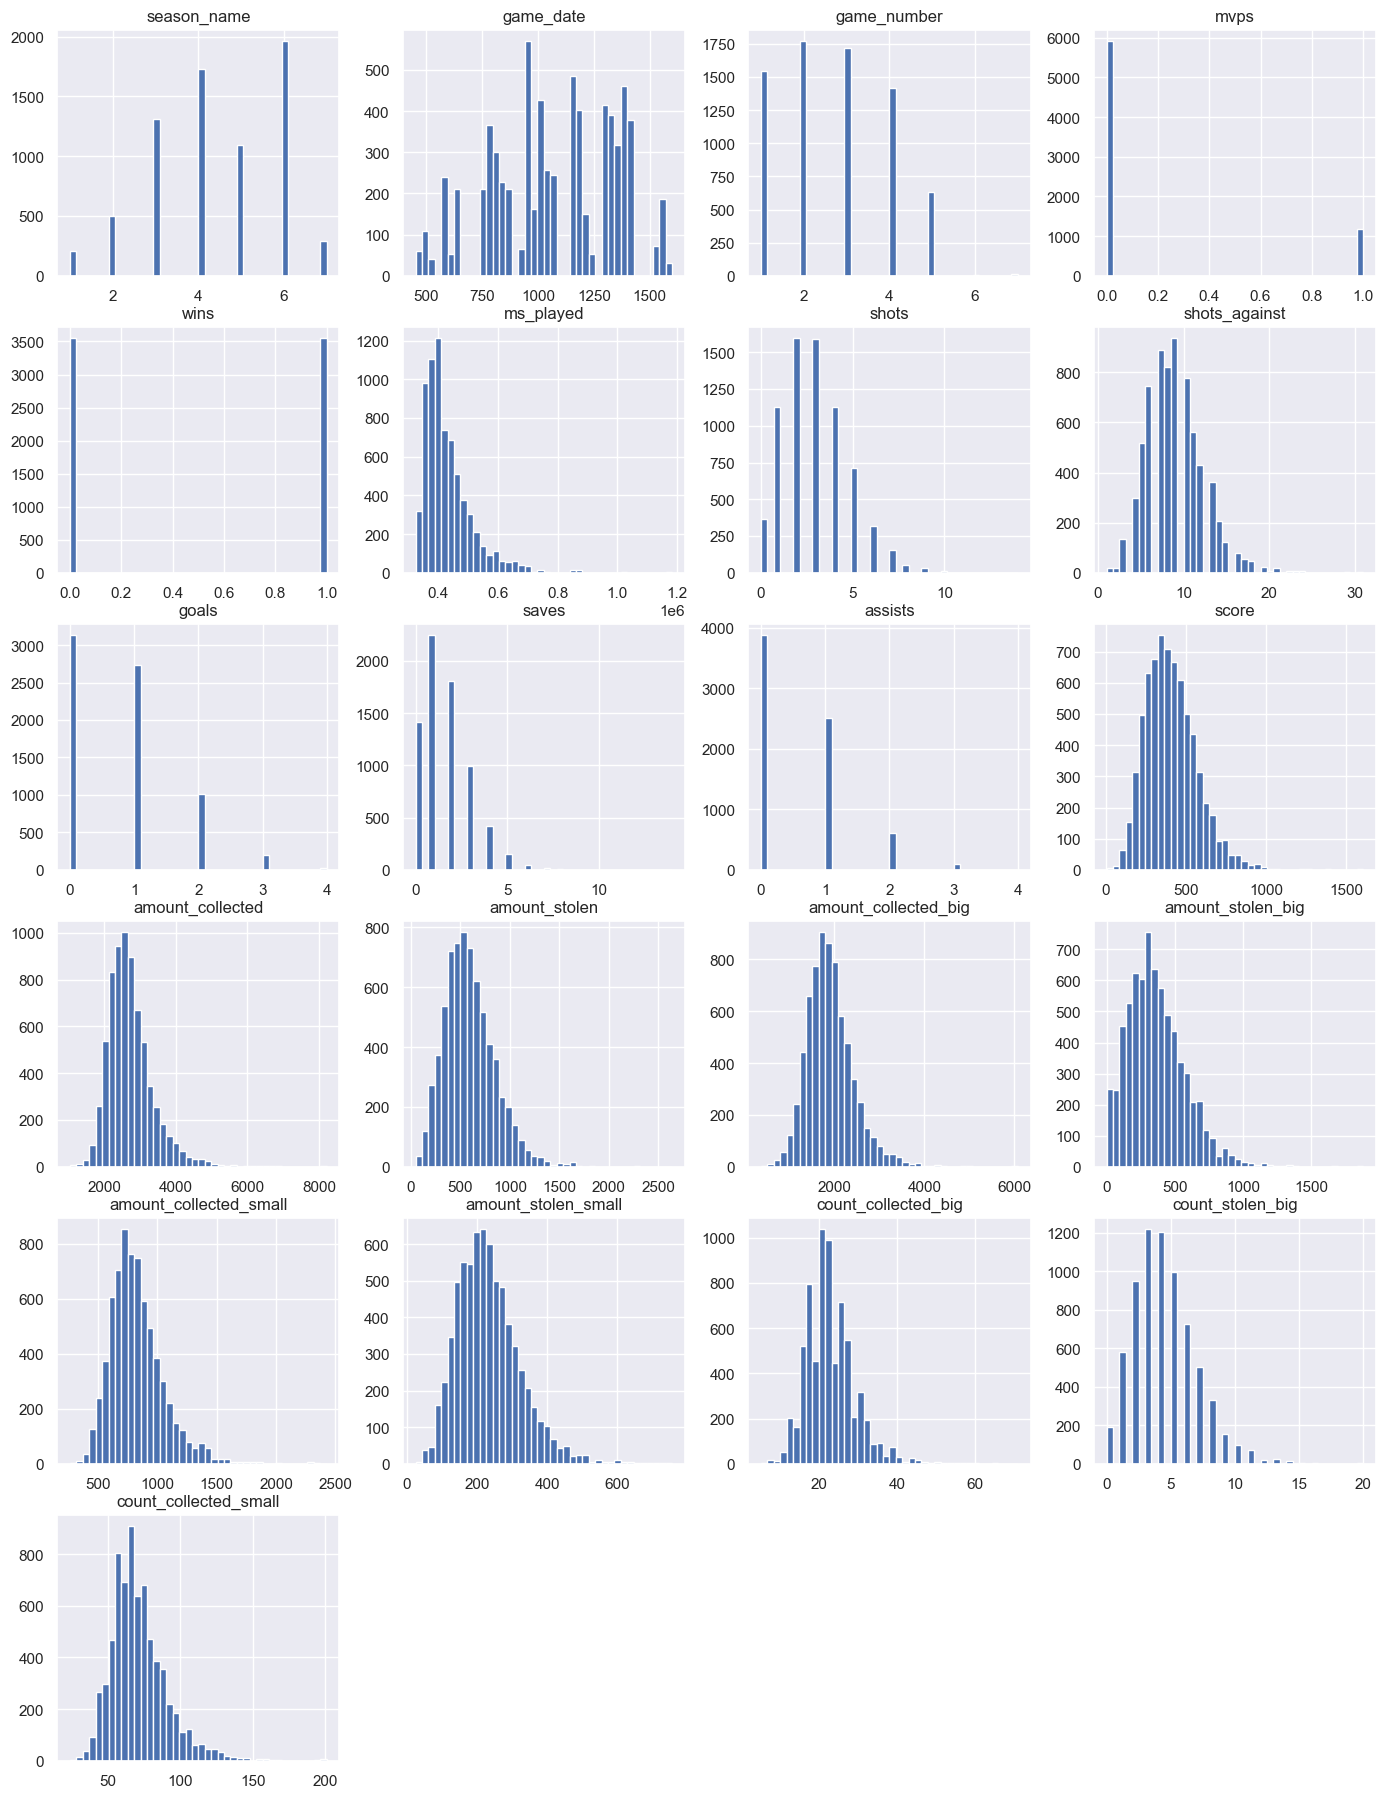

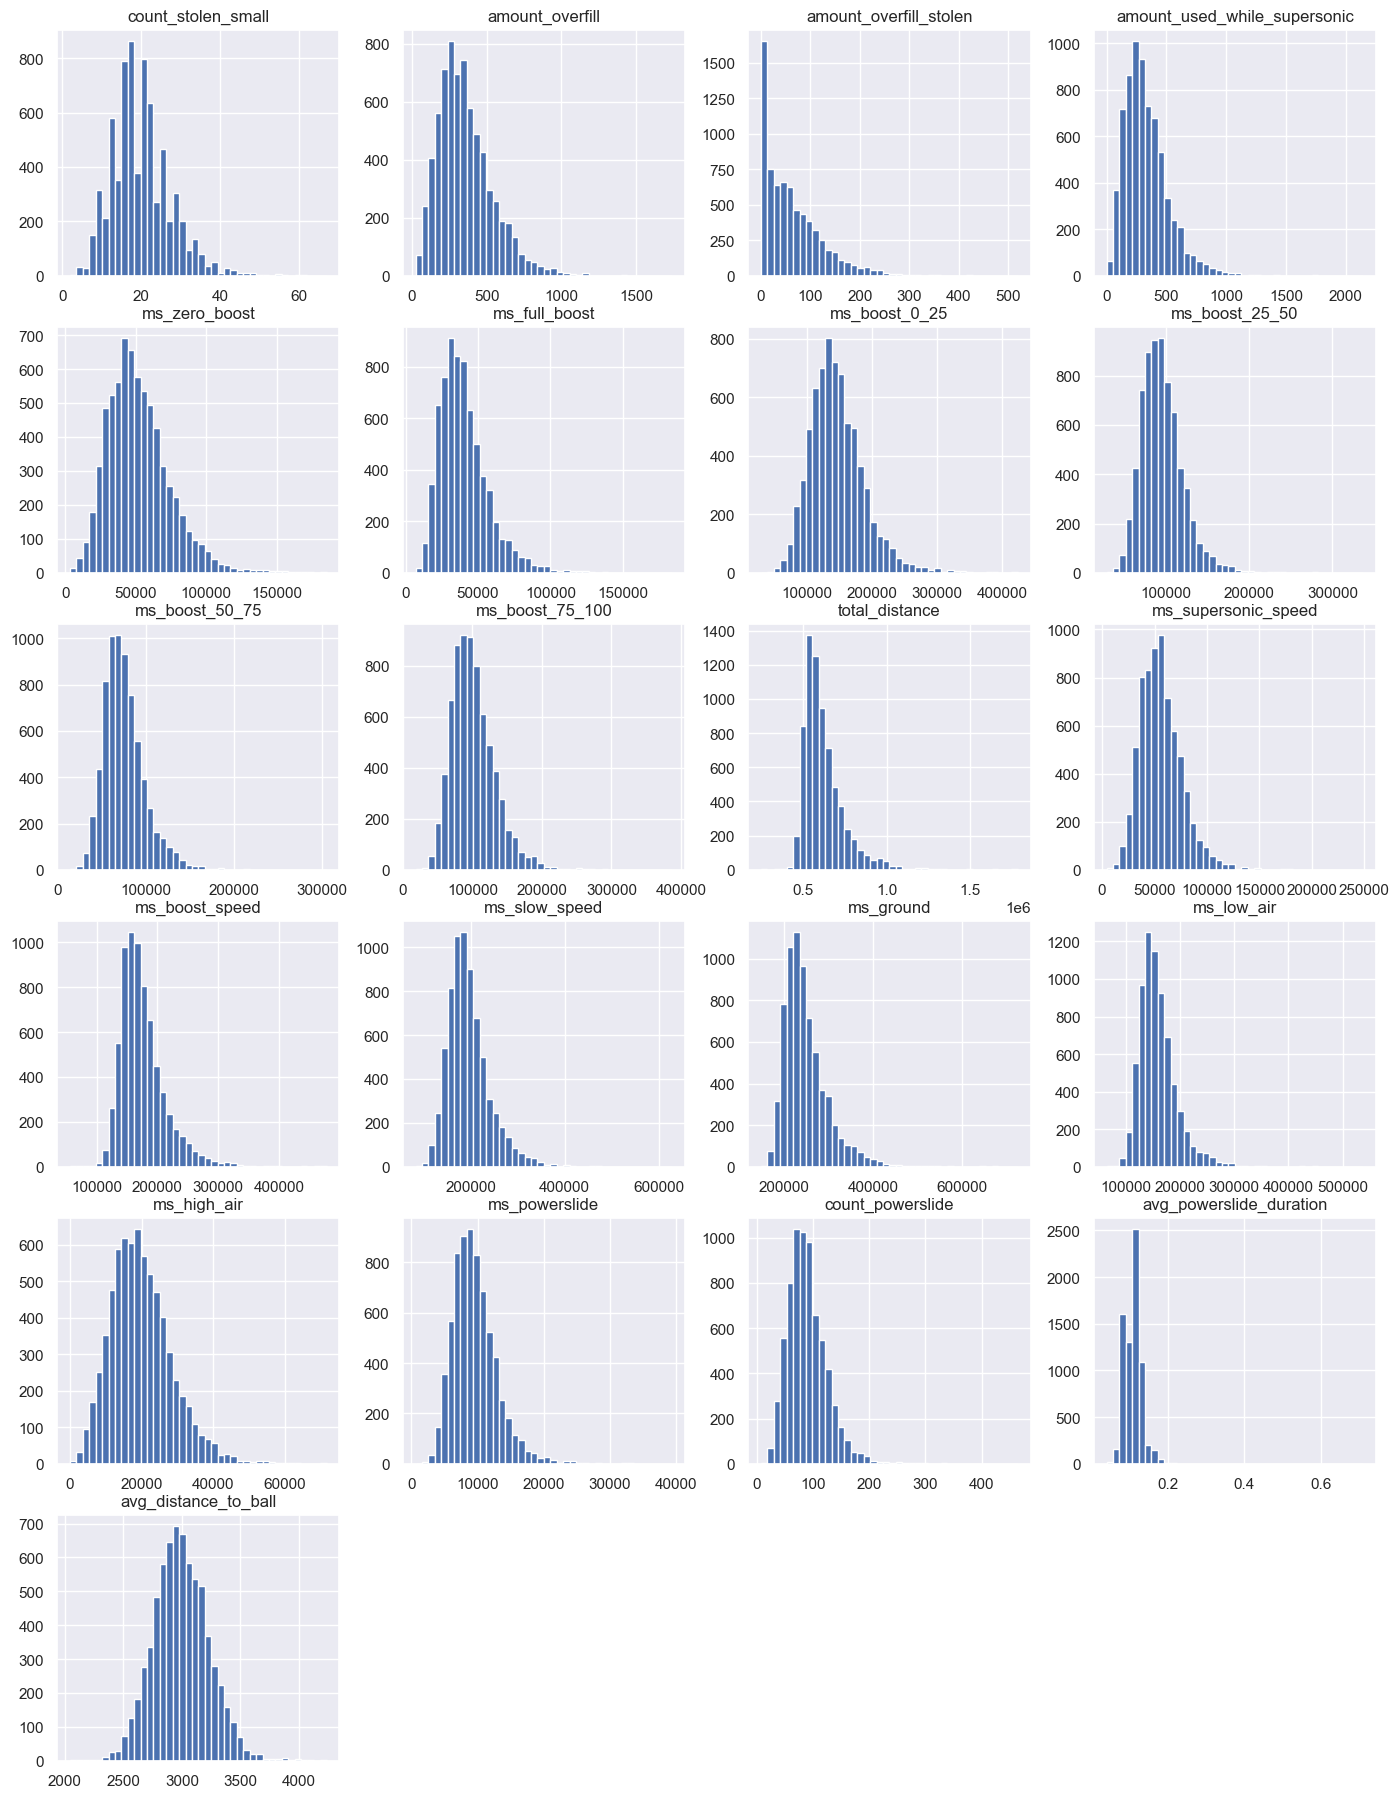

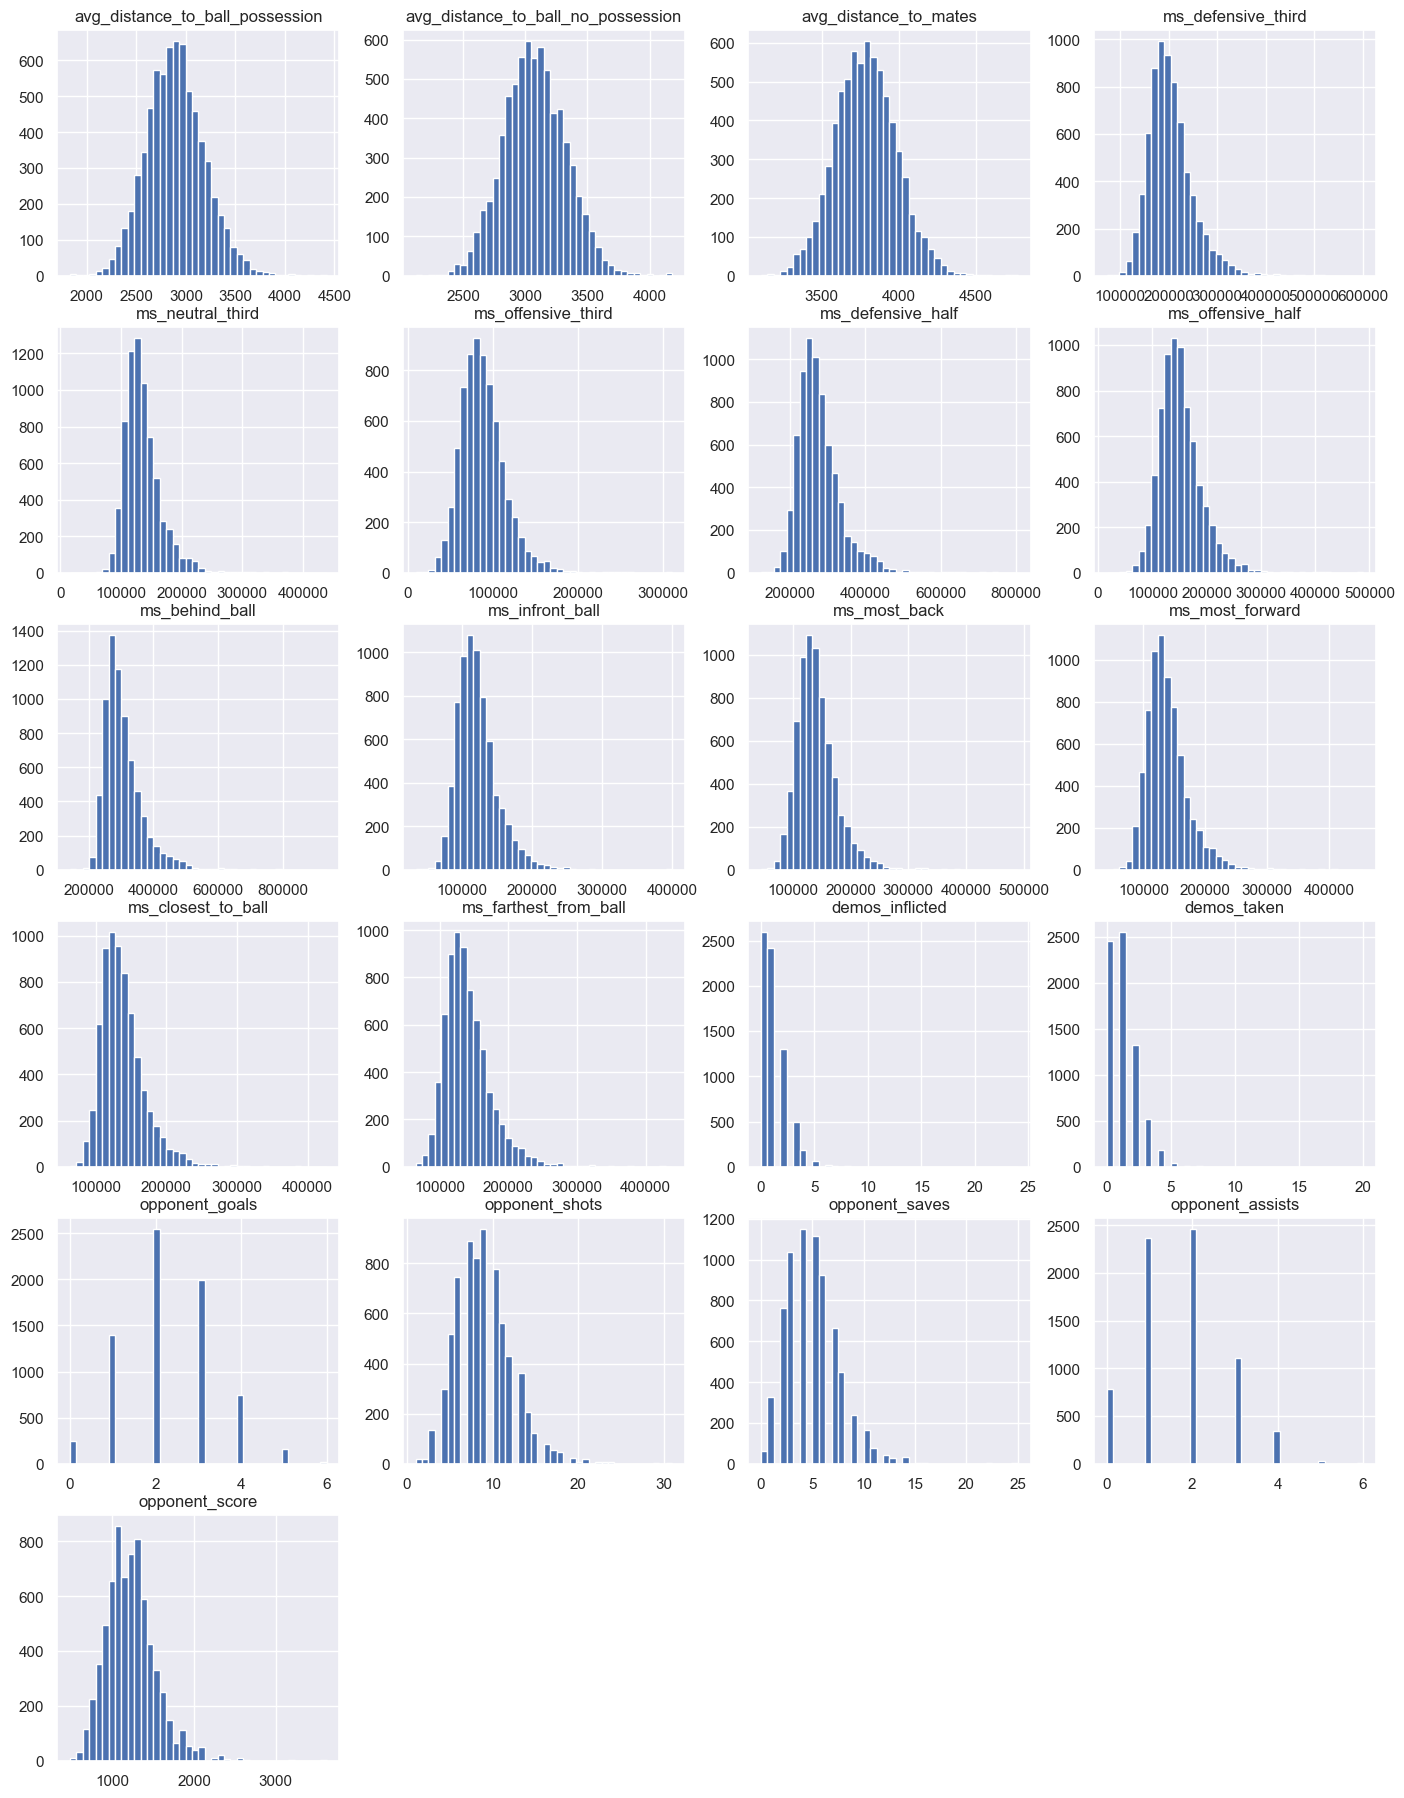

In [105]:
display_df = data.select_dtypes(include=['int64', 'float64'])
n = len(display_df.columns)
n_per_fig = n // 3  # calculate number of columns per figure

# Create three figures
for i in range(3):
    start = i * n_per_fig
    end = (i+1) * n_per_fig if i != 2 else None  # go to end for last figure
    columns = display_df.columns[start:end]
    
    rows = len(columns)//4 + (len(columns)%4 != 0)  # calculate number of rows necessary for 4 columns

    fig, a = plt.subplots(rows, 4, figsize=(14, 3*rows))  # adjust size as necessary
    fig.tight_layout()

    for j, c in enumerate(columns):
        dat = display_df[c]
        ax = a.flat[j]
        if display_df[c].dtype == 'bool':
            display_df[c].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(c)
        else:
            ax.hist(dat, bins=40)
            ax.set_title(c)
        
    # Remove unused subplots
    if len(columns) < rows*4:
        for ax in a.flat[len(columns):]:
            ax.axis('off')

    plt.show()

<Axes: >

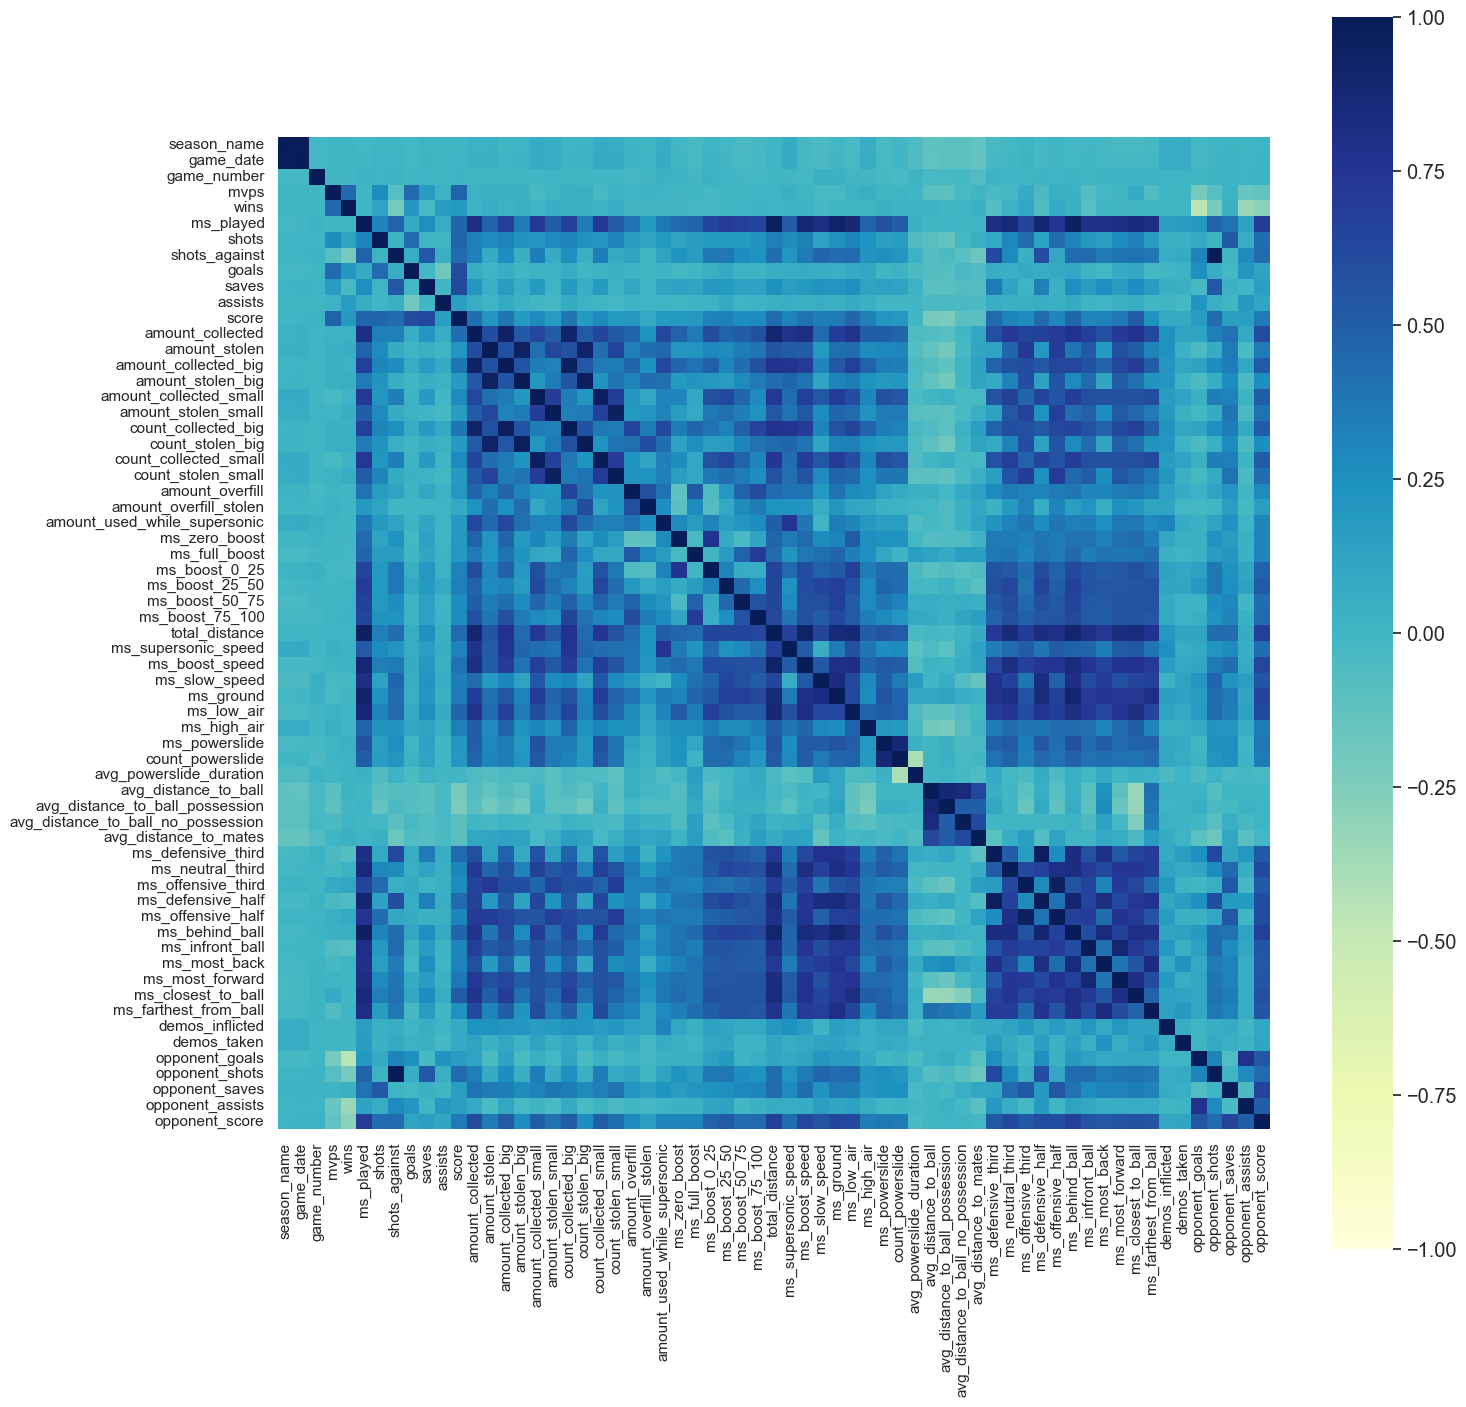

In [106]:
# Look into feature correlation
sns.color_palette("mako", as_cmap=True)
league_corr = display_df.corr()
plt.subplots(figsize=(16,16))
sns.set(font_scale=1.3)
sns.heatmap(data=league_corr, vmin=-1, vmax=1, cmap="YlGnBu", square=True, yticklabels=True)

## Correlations

I am curious whether players have certain properties which correlate to wins or goals better than other players. It would be significant if we could use correlations like that to understand playstyles.

<Axes: >

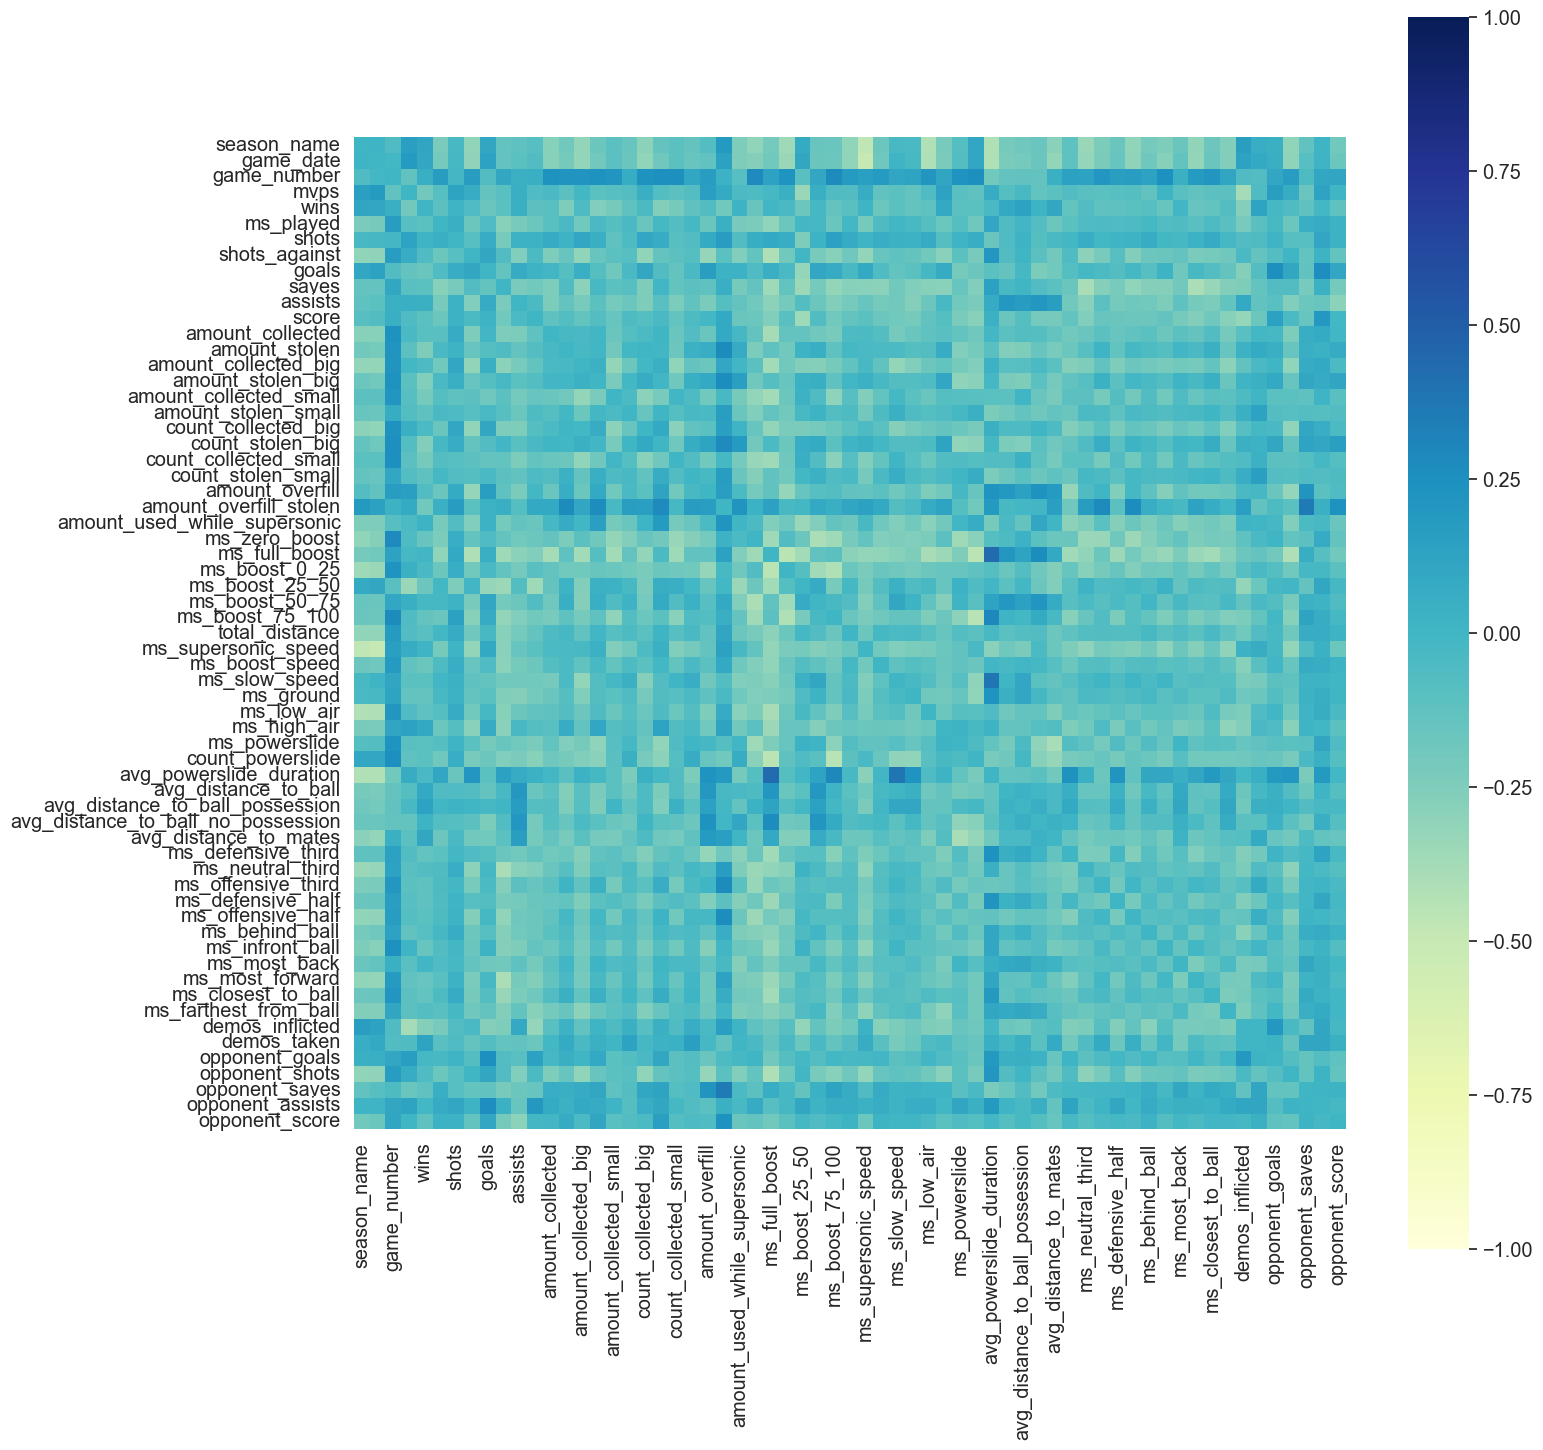

In [107]:
def get_player_corr_dif(data, player_id):
    df = data.select_dtypes(include=['int64', 'float64'])
    league_corr = df.corr()

    player_df = data[data['player_id'] == player_id]
    player_df = player_df.select_dtypes(include=['int64', 'float64'])
    player_corr = player_df.corr()
    return league_corr - player_corr

w0lf_id = '600c994b2c38930008d9cbe6'

plt.subplots(figsize=(16,16))
sns.set(font_scale=1.3)
sns.heatmap(data=get_player_corr_dif(data, w0lf_id), vmin=-1, vmax=1, cmap="YlGnBu", square=True, yticklabels=True)

charting Flow


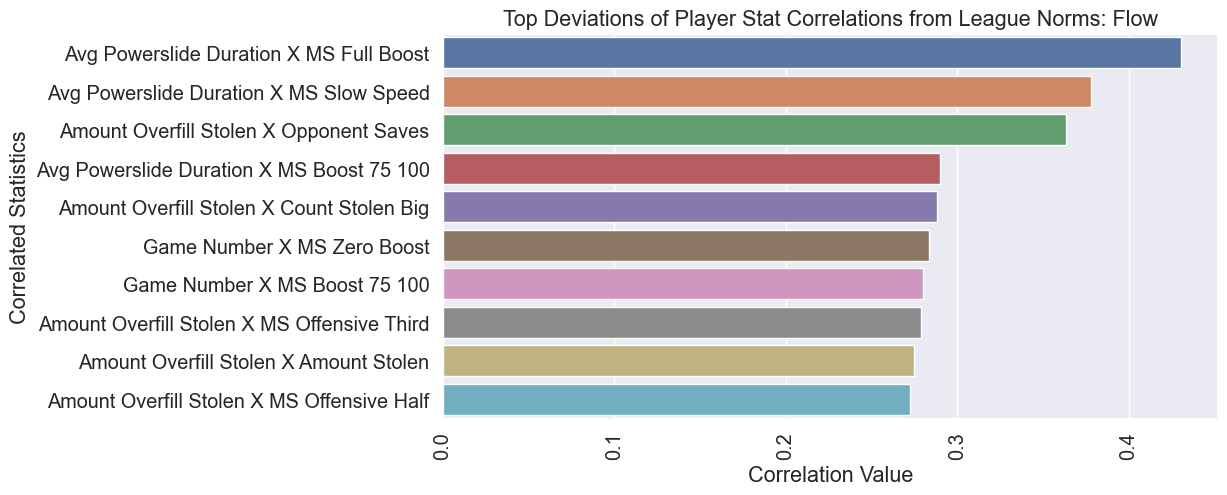

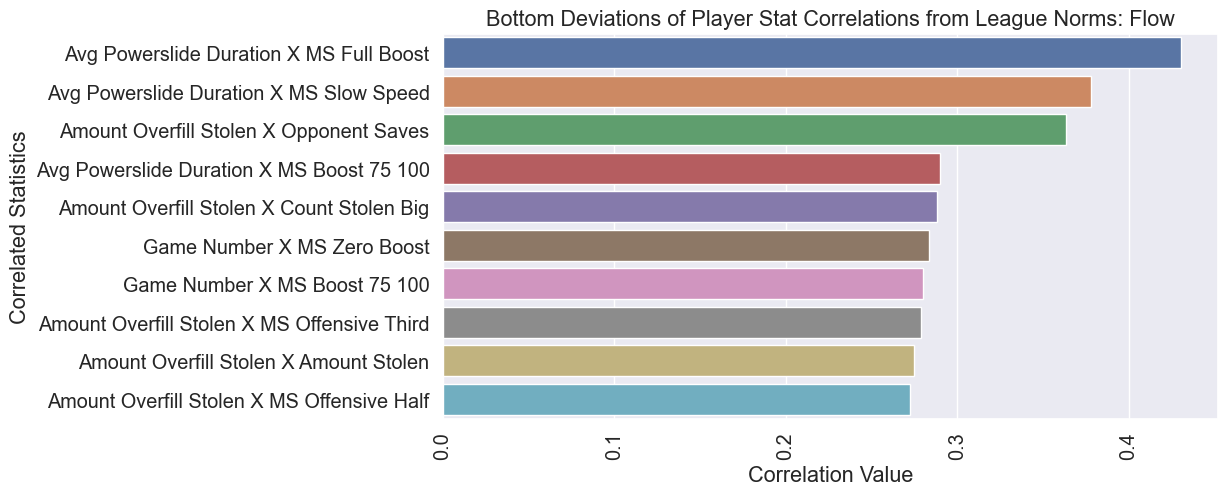

In [108]:
def correlated_series_to_chart(series, title='Top 10 Values'):
    def pretty_name(name: str):
        return name.replace('_', ' ').title().replace('Ms', 'MS')

    # Sort the tuples
    series.index = series.index.map(sorted)

    # Convert list of tuples back to tuple
    series.index = series.index.map(tuple)

    # Drop duplicates
    series = series.loc[~series.index.duplicated(keep='first')]

    # Reset index and create new DataFrame
    series_df = series.reset_index()
    series_df.columns = ['Row', 'Column', 'Value']

    # Concatenate the 'Row' and 'Column' fields into a new 'Label' field
    series_df['Label'] = series_df['Row'].map(str).map(pretty_name) + " X " + series_df['Column'].map(str).map(pretty_name)

    series_df = series_df.drop_duplicates()

    # Now you can plot 'Value' against 'Label'
    plt.figure(figsize=(10,5))
    sns.barplot(y='Label', x='Value', data=series_df, orient='h')
    plt.title(title)
    plt.ylabel('Correlated Statistics')
    plt.xlabel('Correlation Value')
    plt.xticks(rotation=90)
    plt.show()

def create_player_correlation_charts(df, player_id, num_correlations=10):
    dif = get_player_corr_dif(df, player_id)
    player_name = get_player_name_by_id(player_id)
    print('charting', player_name)
    s = dif.unstack()
    correlated_series_to_chart(s.nlargest(num_correlations * 2), f'Top Deviations of Player Stat Correlations from League Norms: {player_name}')
    correlated_series_to_chart(s.nlargest(num_correlations * 2), f'Bottom Deviations of Player Stat Correlations from League Norms: {player_name}')

create_player_correlation_charts(data, w0lf_id)

charting Tero


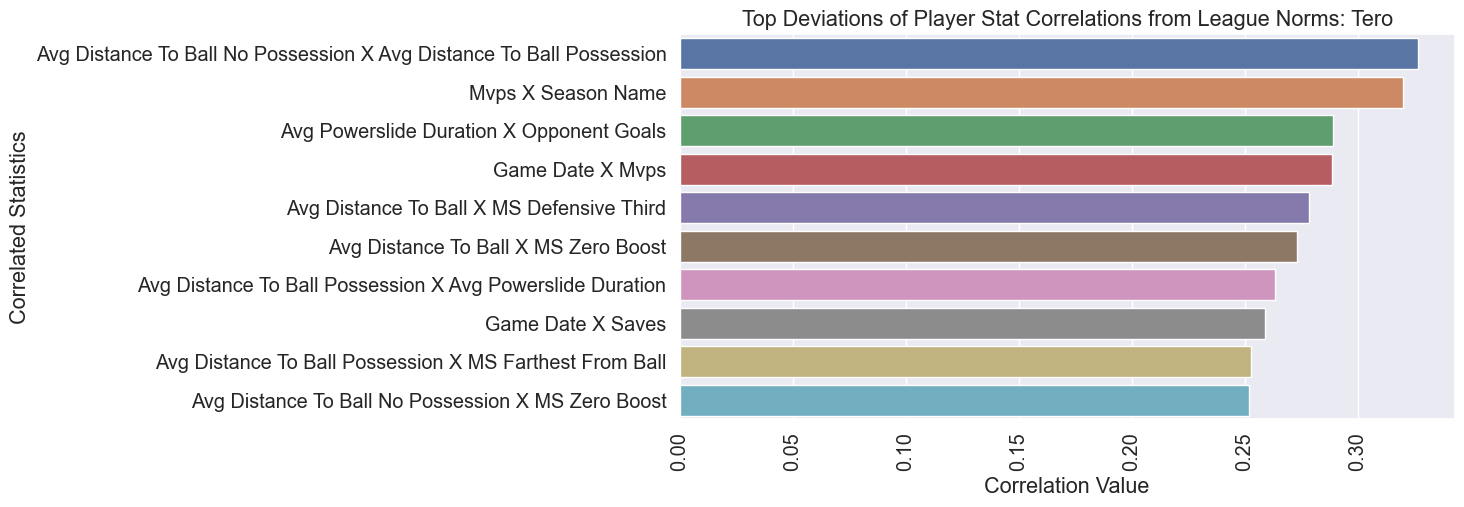

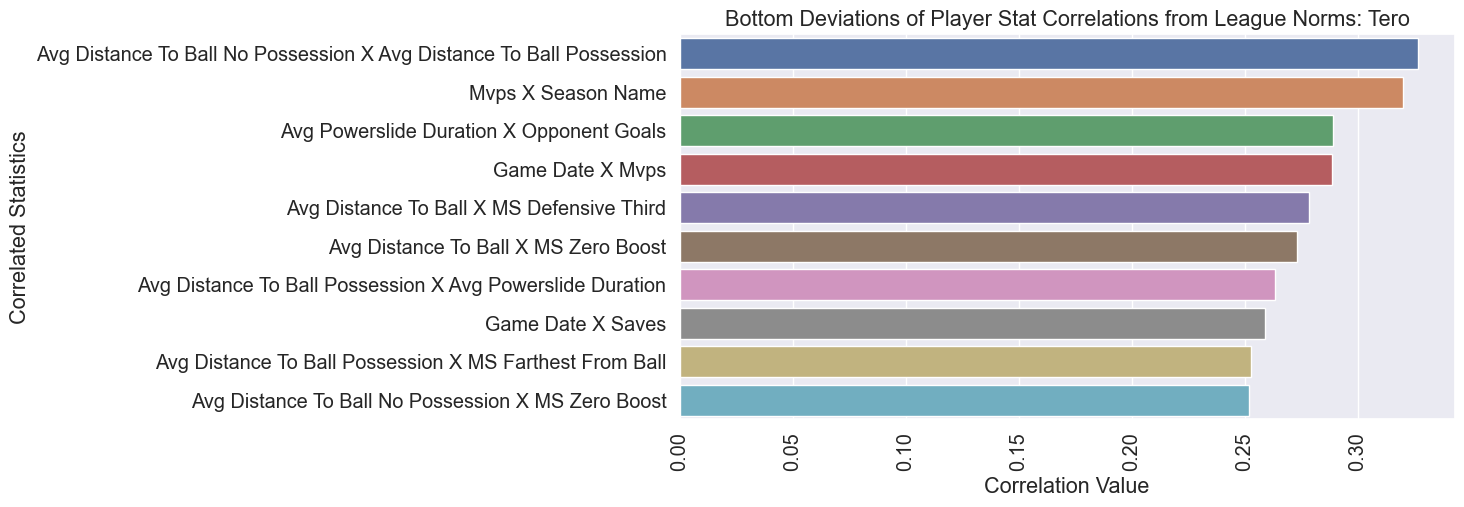

In [109]:
create_player_correlation_charts(data, '5ec9358f8c0dd900074685c7')

charting ambrosia


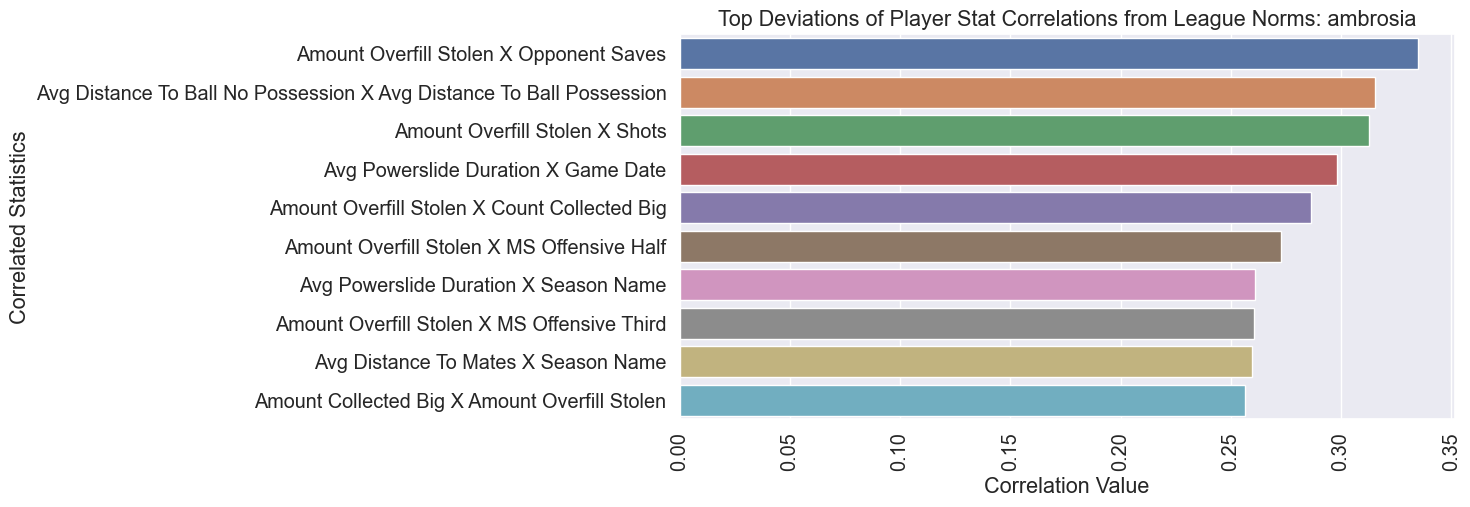

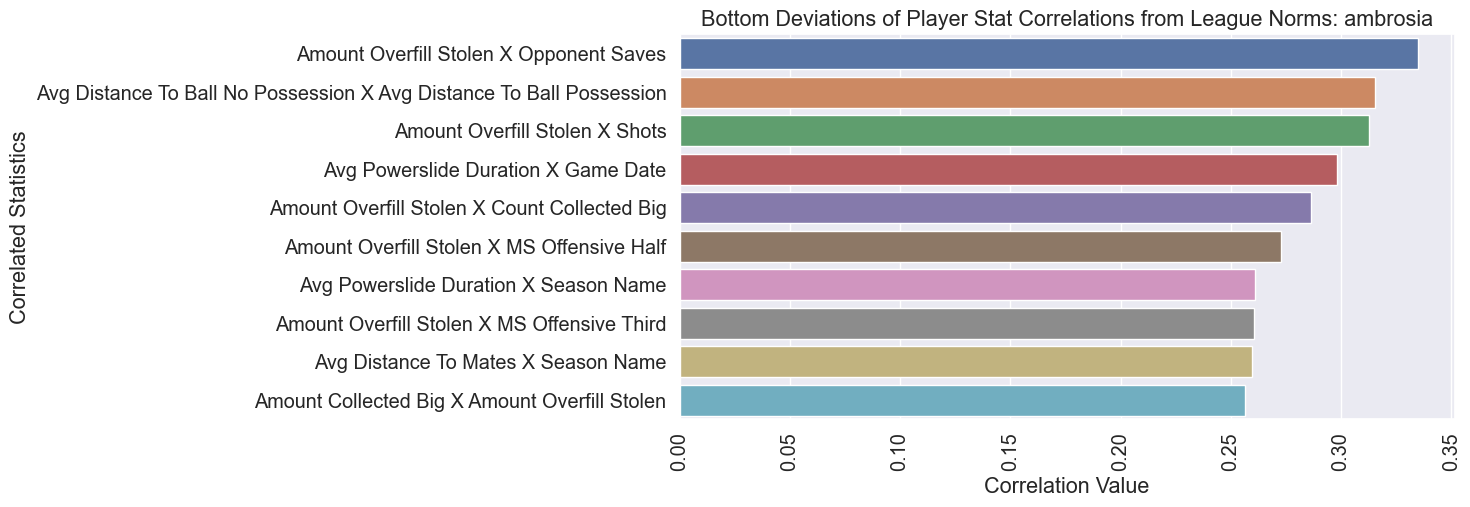

In [110]:
create_player_correlation_charts(data, '5ec9358f8c0dd900074685df')

charting Dicey


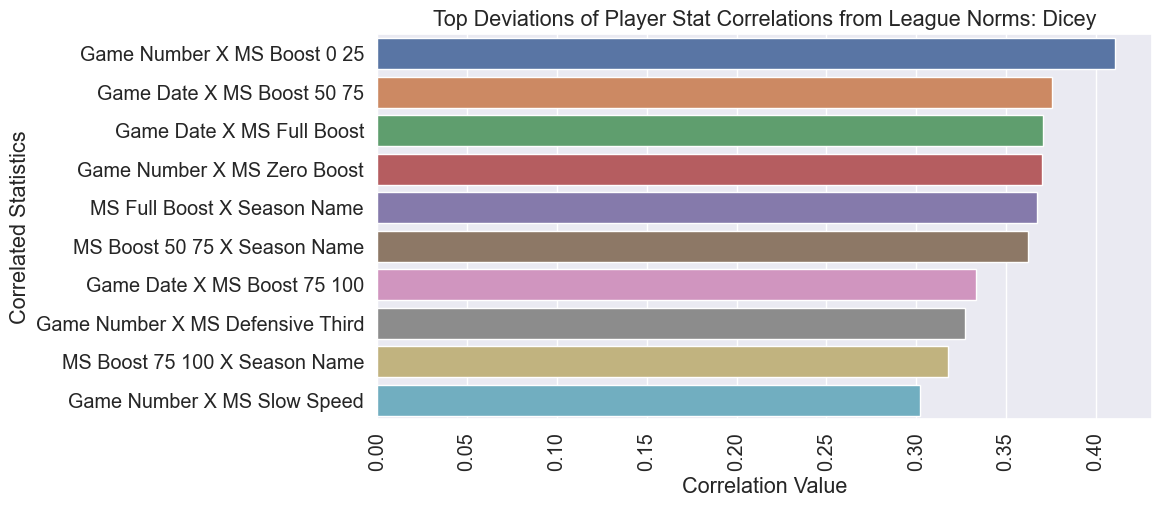

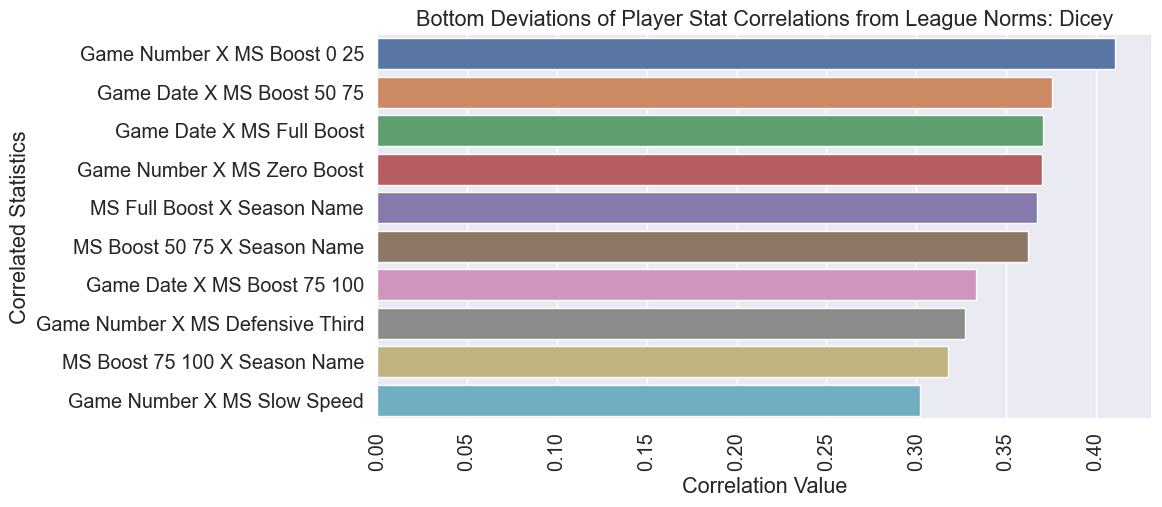

In [111]:
create_player_correlation_charts(data, '5ec935928c0dd9000746860f')

charting ryker


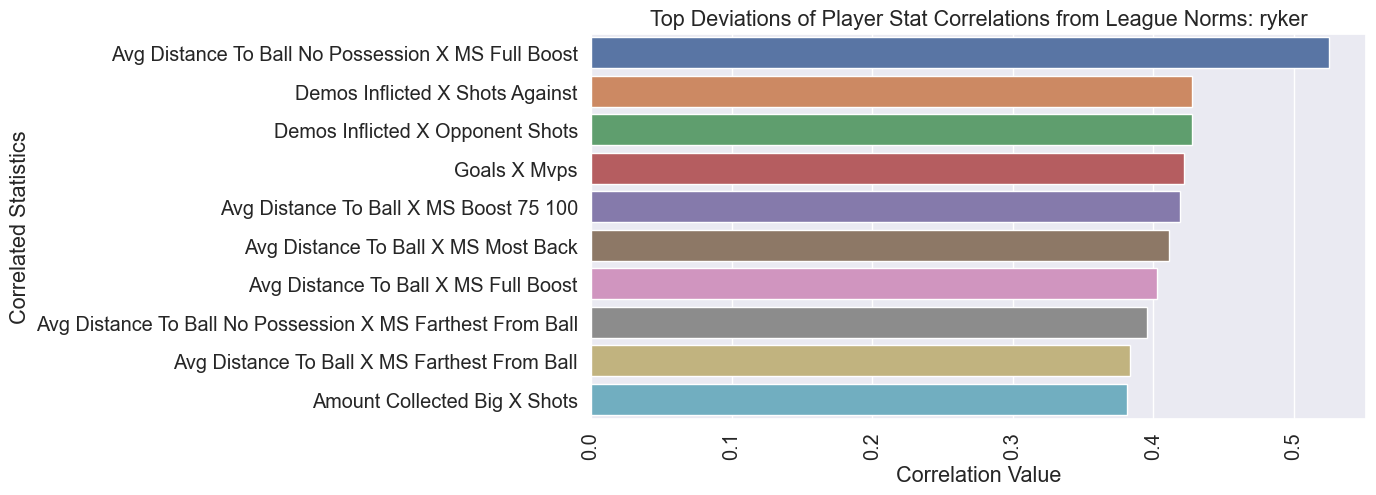

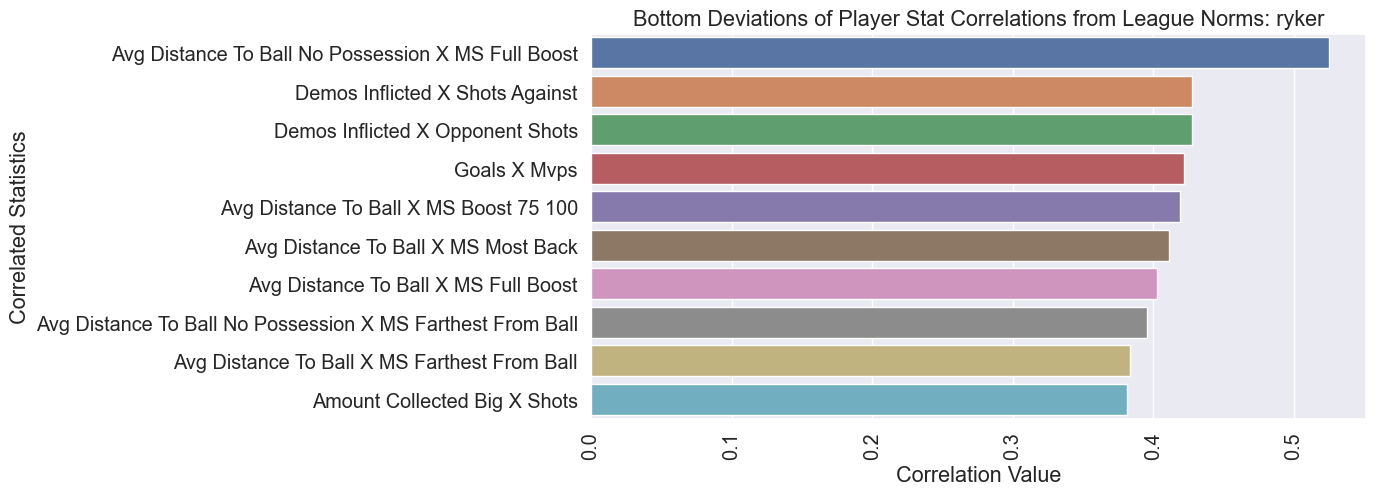

In [112]:

create_player_correlation_charts(data, '60eb9cffce9d6800082487b5')

charting Slip


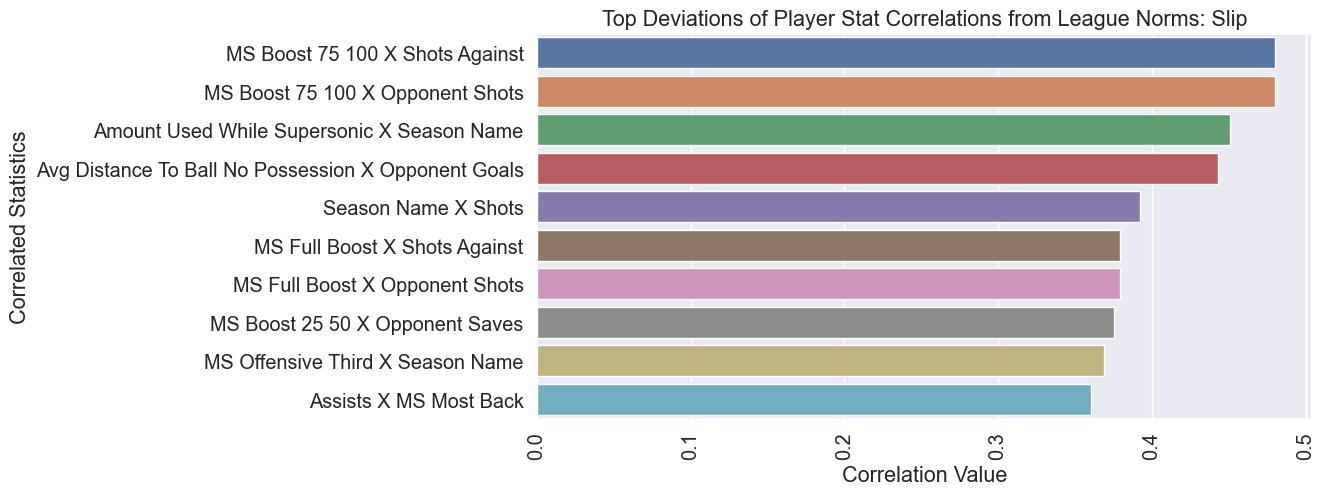

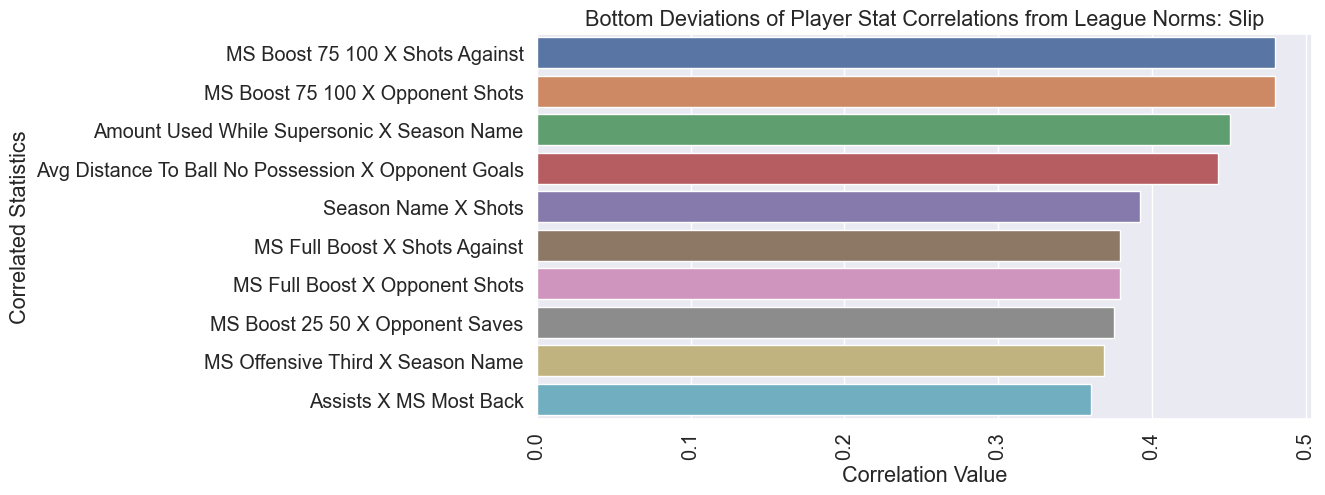

In [113]:
create_player_correlation_charts(data, '60eb9ed67335fb00083ee141')

None of the positive/negative correlations struck me too much by surprise. The negative correlation between `ms_infront_ball` and `wins` is the one I was most curious about. Practically, I wonder if that is due to the ball being "over the defenders' heads" a lot in games that they lost, or whether it would be due to an over-aggression getting teams into trouble.

I want to know if certain correlation paris (such as ms_infront_ball x wins) correlate differently for different players. The investigation below revealed a couple of interesting takeaways. One observation was that we needed to only look at players with a minimum number of games played to avoid huge outliers on charts. I picked 30, since that's the number of observations typically needed for statistical significance. The other is that `ms_infront_ball` is negative for every player in the league, for all of history.

I am curious, and may potentially investigate further, whether there are any fields that tend to be higher for premier players (or whether we could identify premier-caliber players more easily using a certain metric or combination of metrics).

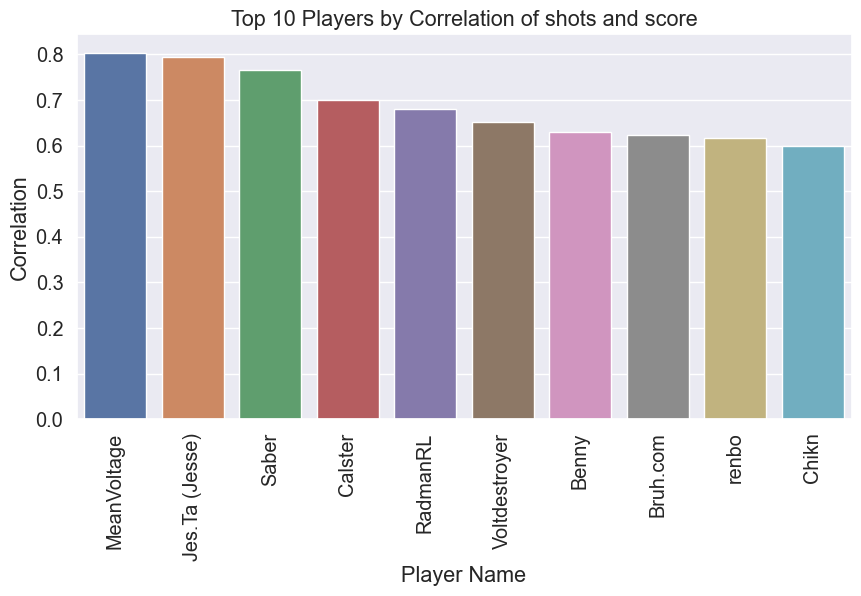

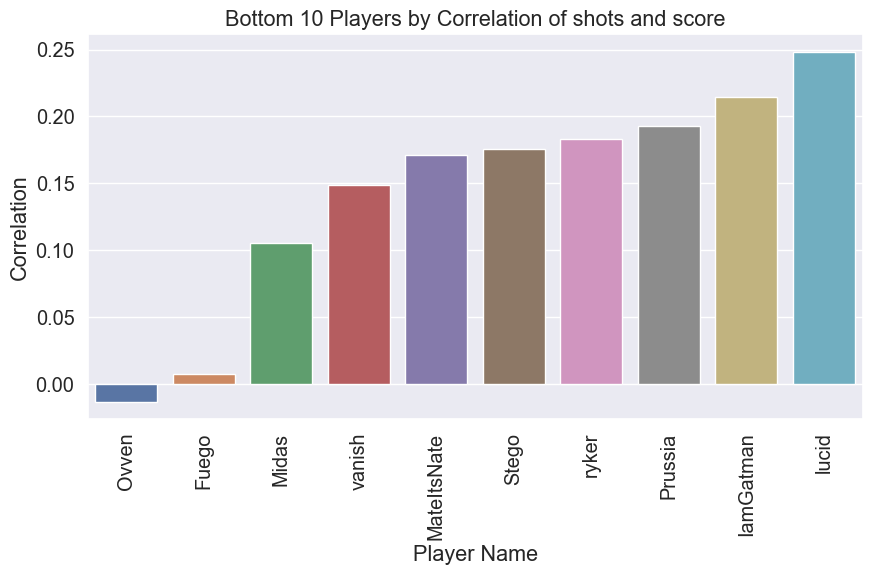

(                  player_id     player_name         0
 6  6144ed1571808a000992cb46     MeanVoltage  0.803669
 8  5f860cf8b607e300088048d1  Jes.Ta (Jesse)  0.794819
 5  600c99a5eedc0d0008211484           Saber  0.766174
 1  5ec9358f8c0dd900074685ca         Calster  0.698955
 9  5ec935928c0dd90007468614        RadmanRL  0.681042
 2  610ef746fcc4b40009036428   Voltdestroyer  0.650650
 7  600c993b2c38930008d9cbe2           Benny  0.629732
 4  600c9b8deedc0d00082114ac        Bruh.com  0.622457
 3  60f4badcba91280008087558           renbo  0.616455
 0  5f2b812976113c0008fcee73           Chikn  0.598761,
                   player_id  player_name         0
 3  5ec9358f8c0dd900074685d8        Ovven -0.013338
 7  6208204c660ef60009f50602        Fuego  0.007072
 6  6144ecc571808a000992cb3e        Midas  0.105596
 8  6144ecec71808a000992cb43       vanish  0.148890
 2  5f2c5c74bb182500085b6df4  MateItsNate  0.171072
 4  5f2c5ce3754b2f00087df2b6        Stego  0.175425
 0  60eb9cffce9d6800082487b5  

In [114]:
def create_correlation_charts(axis1, axis2):
    # Filter player_ids with more than 30 records
    players_with_enough_data = data.groupby('player_id').filter(lambda x: len(x) > 30)

    # Calculate correlations for each player
    player_correlations = players_with_enough_data.groupby('player_id').apply(lambda x: x[axis1].corr(x[axis2]))

    # Get top 10 and bottom 10 players by correlation
    top_10_players = player_correlations.nlargest(10)
    bottom_10_players = player_correlations.nsmallest(10)

    # Create DataFrame from top_10_players and bottom_10_players Series
    top_10_players_df = top_10_players.reset_index()
    bottom_10_players_df = bottom_10_players.reset_index()

    # Merge player_id_map with top_10_players and bottom_10_players
    top_10_players_df = player_id_map.merge(top_10_players_df, on='player_id', how='inner')
    bottom_10_players_df = player_id_map.merge(bottom_10_players_df, on='player_id', how='inner')

    # Sort values before plotting
    top_10_players_df = top_10_players_df.sort_values(by=0, ascending=False)
    bottom_10_players_df = bottom_10_players_df.sort_values(by=0)

    chart_name = f'Correlation of {axis1} and {axis2}'

    # Plot top 10 players
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_10_players_df['player_name'], y=top_10_players_df[0])
    plt.title('Top 10 Players by ' + chart_name)
    plt.xlabel('Player Name')
    plt.ylabel('Correlation')
    plt.xticks(rotation=90)
    plt.show()

    # Plot bottom 10 players
    plt.figure(figsize=(10,5))
    sns.barplot(x=bottom_10_players_df['player_name'], y=bottom_10_players_df[0])
    plt.title('Bottom 10 Players by ' + chart_name)
    plt.xlabel('Player Name')
    plt.ylabel('Correlation')
    plt.xticks(rotation=90)
    plt.show()

    return (top_10_players_df, bottom_10_players_df)

create_correlation_charts('shots', 'score')

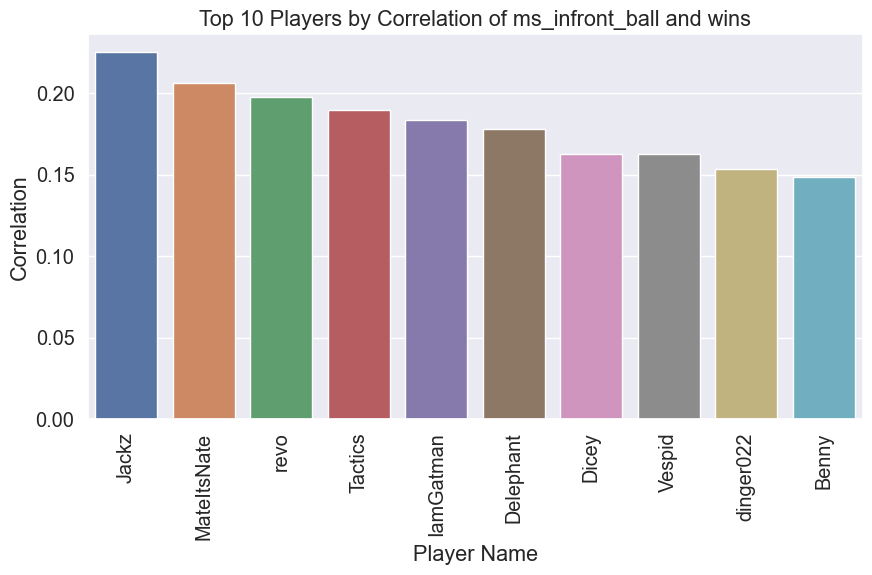

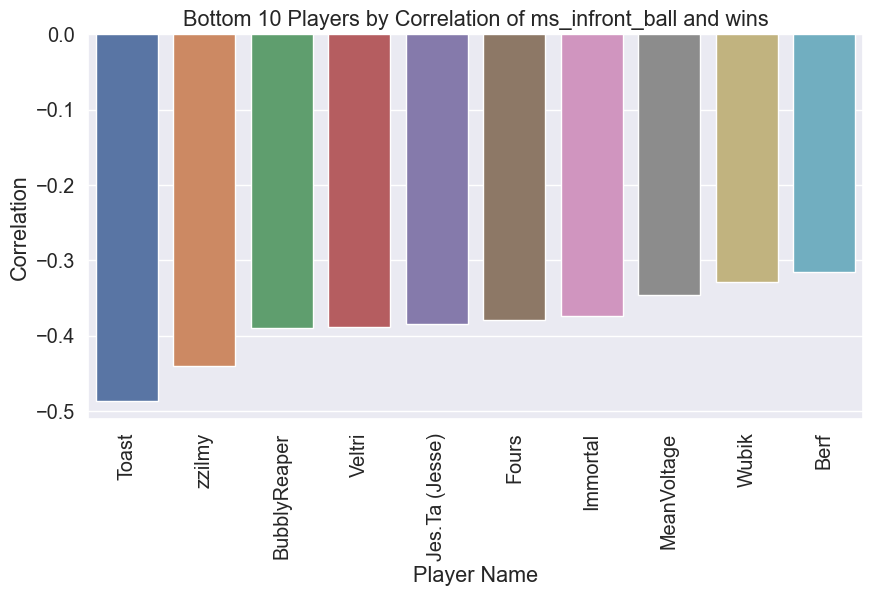

(                  player_id  player_name         0
 3  600c9a5b2c38930008d9cbfc        Jackz  0.224866
 4  5f2c5c74bb182500085b6df4  MateItsNate  0.206061
 7  5f2c5c93bb182500085b6df6         revo  0.197672
 8  5f2c5cac754b2f00087df2b2      Tactics  0.189778
 0  5ec9358f8c0dd900074685c8    IamGatman  0.183172
 6  5ec9358f8c0dd900074685cc    Delephant  0.178033
 5  5ec935928c0dd9000746860f        Dicey  0.162820
 2  5f2c5d31bb182500085b6e0d       Vespid  0.162646
 1  600c9b08eedc0d00082114a3    dinger022  0.153184
 9  600c993b2c38930008d9cbe2        Benny  0.148512,
                   player_id     player_name         0
 5  601265ddeba52b000847388d           Toast -0.486807
 7  60f4ba1eba91280008087542          zzilmy -0.440389
 0  62226bcb85b38d0009b15b86    BubblyReaper -0.390613
 4  5ec9358f8c0dd900074685d9          Veltri -0.388523
 9  5f860cf8b607e300088048d1  Jes.Ta (Jesse) -0.384481
 1  620822b1b819180009b4e661           Fours -0.379415
 6  5ec935928c0dd90007468626        Immort

In [115]:
create_correlation_charts('ms_infront_ball', 'wins')

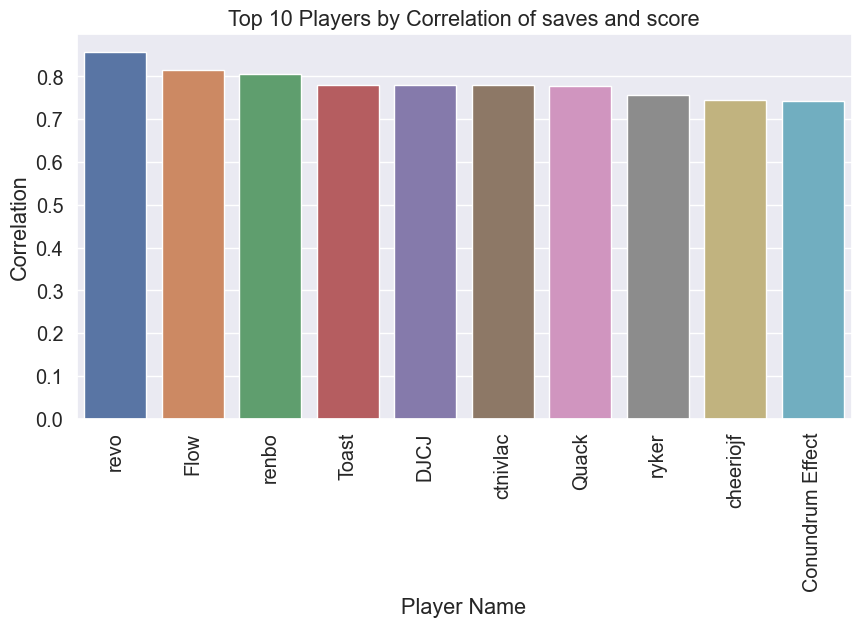

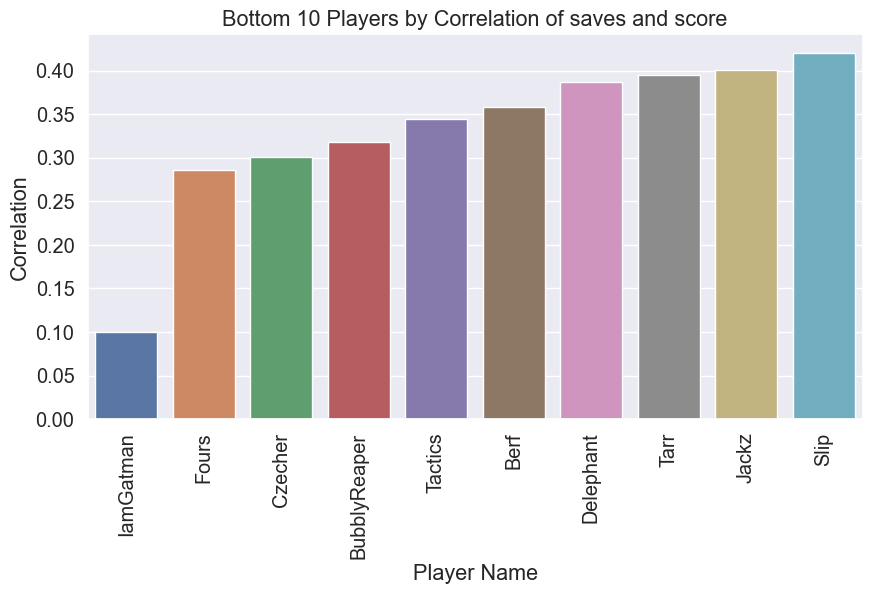

(                  player_id       player_name         0
 7  5f2c5c93bb182500085b6df6              revo  0.856865
 2  600c994b2c38930008d9cbe6              Flow  0.814140
 1  60f4badcba91280008087558             renbo  0.804868
 6  601265ddeba52b000847388d             Toast  0.780872
 3  5fdad449c90cc90009196cda              DJCJ  0.780115
 5  6205b4d81876ea0009d5b3de          ctnivlac  0.779087
 8  5ec935928c0dd90007468624             Quack  0.777526
 0  60eb9cffce9d6800082487b5             ryker  0.757688
 9  5ec9358f8c0dd900074685d2         cheeriojf  0.743755
 4  5ec9358f8c0dd900074685e3  Conundrum Effect  0.742873,
                   player_id   player_name         0
 0  5ec9358f8c0dd900074685c8     IamGatman  0.099601
 3  620822b1b819180009b4e661         Fours  0.286241
 9  5f2c5c5b754b2f00087df2a8       Czecher  0.300474
 2  62226bcb85b38d0009b15b86  BubblyReaper  0.317737
 8  5f2c5cac754b2f00087df2b2       Tactics  0.344034
 4  600c992aeedc0d0008211475          Berf  0.357636
 

In [116]:
create_correlation_charts('saves', 'score')

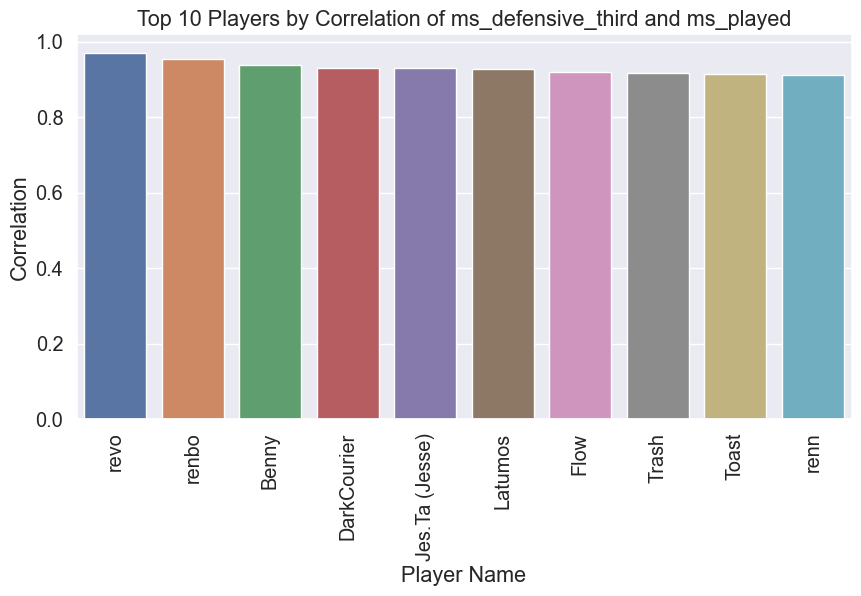

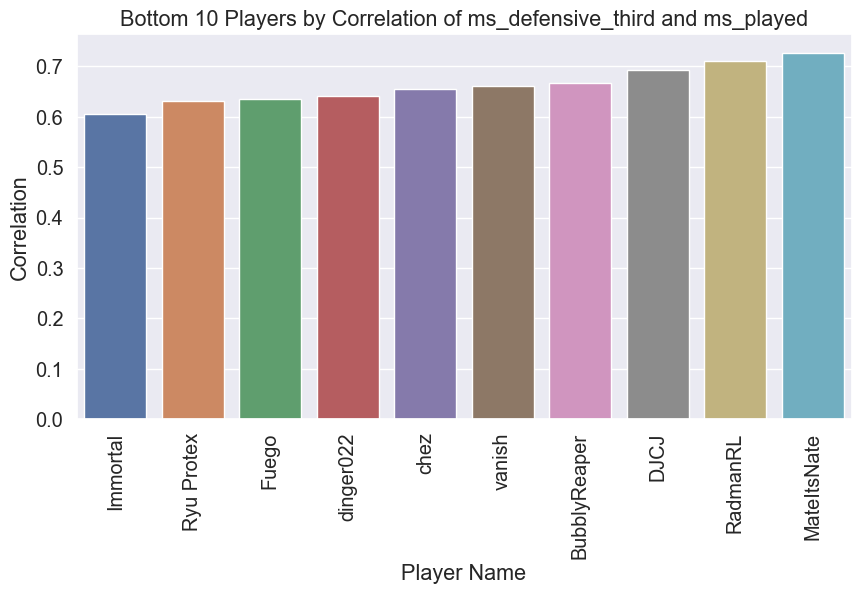

(                  player_id     player_name         0
 6  5f2c5c93bb182500085b6df6            revo  0.971170
 2  60f4badcba91280008087558           renbo  0.954736
 8  600c993b2c38930008d9cbe2           Benny  0.937289
 7  600c9ae7eedc0d00082114a0     DarkCourier  0.930828
 9  5f860cf8b607e300088048d1  Jes.Ta (Jesse)  0.929915
 0  5f2c5145754b2f00087df27f         Latumos  0.928966
 3  600c994b2c38930008d9cbe6            Flow  0.920531
 1  6206ea2345241500090a2c17           Trash  0.917185
 5  601265ddeba52b000847388d           Toast  0.913729
 4  5ec935928c0dd9000746861f            renn  0.913081,
                   player_id   player_name         0
 8  5ec935928c0dd90007468626      Immortal  0.606459
 7  5ec9358f8c0dd900074685e5    Ryu Protex  0.631031
 2  6208204c660ef60009f50602         Fuego  0.636212
 0  600c9b08eedc0d00082114a3     dinger022  0.641570
 4  5ec9358f8c0dd900074685cb          chez  0.654353
 5  6144ecec71808a000992cb43        vanish  0.660744
 3  62226bcb85b38d0009b

In [117]:
create_correlation_charts('ms_defensive_third', 'ms_played')

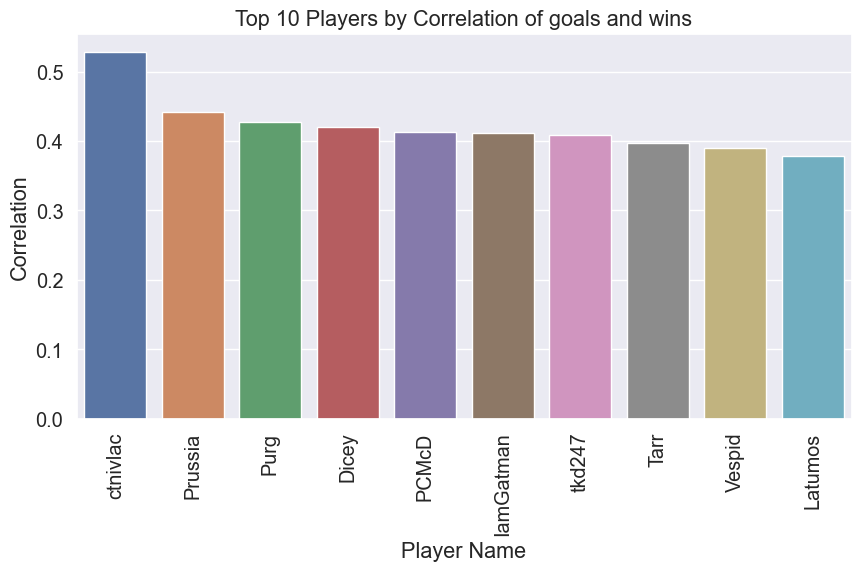

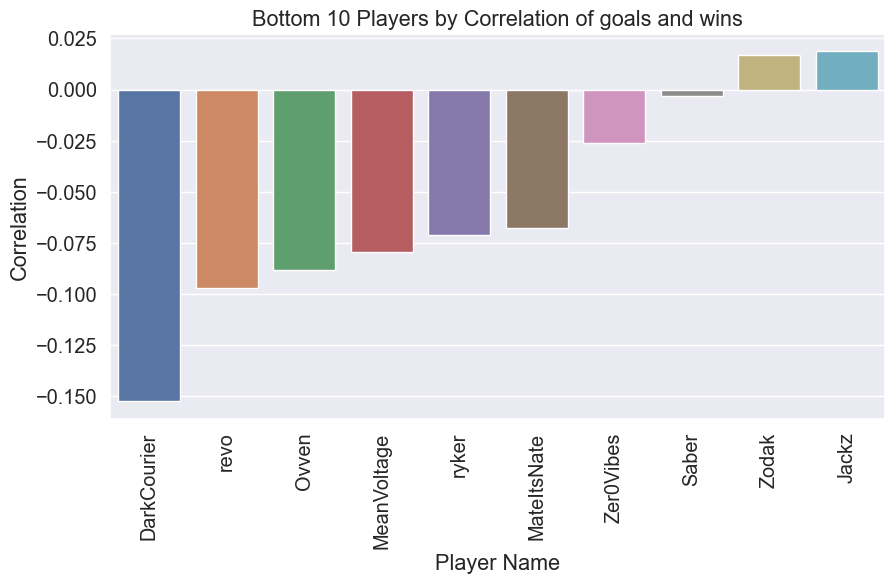

(                  player_id player_name         0
 8  6205b4d81876ea0009d5b3de    ctnivlac  0.528570
 3  5ec9358f8c0dd900074685de     Prussia  0.442277
 5  62081ff2660ef60009f505e5        Purg  0.426732
 6  5ec935928c0dd9000746860f       Dicey  0.419521
 2  600c9916eedc0d0008211473       PCMcD  0.412765
 0  5ec9358f8c0dd900074685c8   IamGatman  0.412125
 7  5f2c5c47bb182500085b6de8      tkd247  0.409110
 9  5ec935928c0dd9000746861c        Tarr  0.397421
 1  5f2c5d31bb182500085b6e0d      Vespid  0.390208
 4  5f2c5145754b2f00087df27f     Latumos  0.378578,
                   player_id  player_name         0
 8  600c9ae7eedc0d00082114a0  DarkCourier -0.152606
 7  5f2c5c93bb182500085b6df6         revo -0.097183
 4  5ec9358f8c0dd900074685d8        Ovven -0.088197
 9  6144ed1571808a000992cb46  MeanVoltage -0.079290
 0  60eb9cffce9d6800082487b5        ryker -0.071040
 3  5f2c5c74bb182500085b6df4  MateItsNate -0.067520
 5  5f2c5d0cbb182500085b6e04    Zer0Vibes -0.026195
 6  600c99a5eedc0d0008

In [118]:
create_correlation_charts('goals', 'wins')

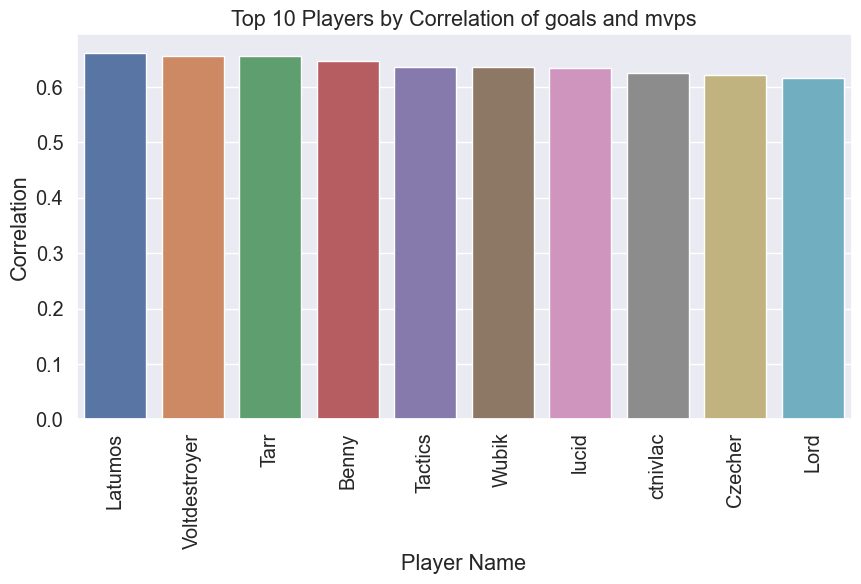

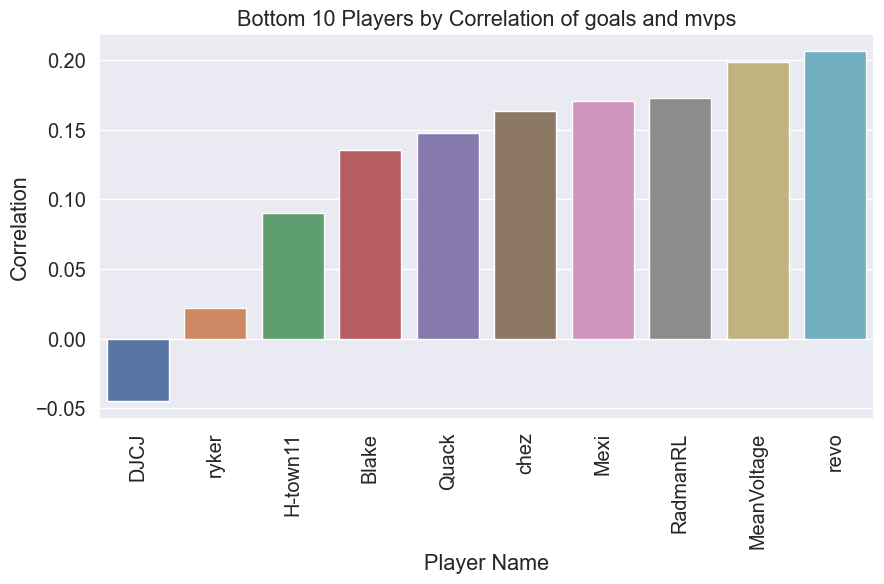

(                  player_id    player_name         0
 0  5f2c5145754b2f00087df27f        Latumos  0.662297
 1  610ef746fcc4b40009036428  Voltdestroyer  0.656678
 5  5ec935928c0dd9000746861c           Tarr  0.656599
 7  600c993b2c38930008d9cbe2          Benny  0.647150
 6  5f2c5cac754b2f00087df2b2        Tactics  0.636330
 2  6027293238b25600095dc3c7          Wubik  0.635371
 9  5f2c504c9682770008b3b01a          lucid  0.634361
 4  6205b4d81876ea0009d5b3de       ctnivlac  0.624819
 8  5f2c5c5b754b2f00087df2a8        Czecher  0.621579
 3  60eb9eca7335fb00083ee13c           Lord  0.617260,
                   player_id  player_name         0
 3  5fdad449c90cc90009196cda         DJCJ -0.045070
 0  60eb9cffce9d6800082487b5        ryker  0.021897
 6  600c9ad02c38930008d9cc09     H-town11  0.090228
 7  600c98fd2c38930008d9cbda        Blake  0.135353
 8  5ec935928c0dd90007468624        Quack  0.147859
 2  5ec9358f8c0dd900074685cb         chez  0.163098
 1  5ec9358f8c0dd900074685e2         Mexi

In [119]:
create_correlation_charts('goals', 'mvps')

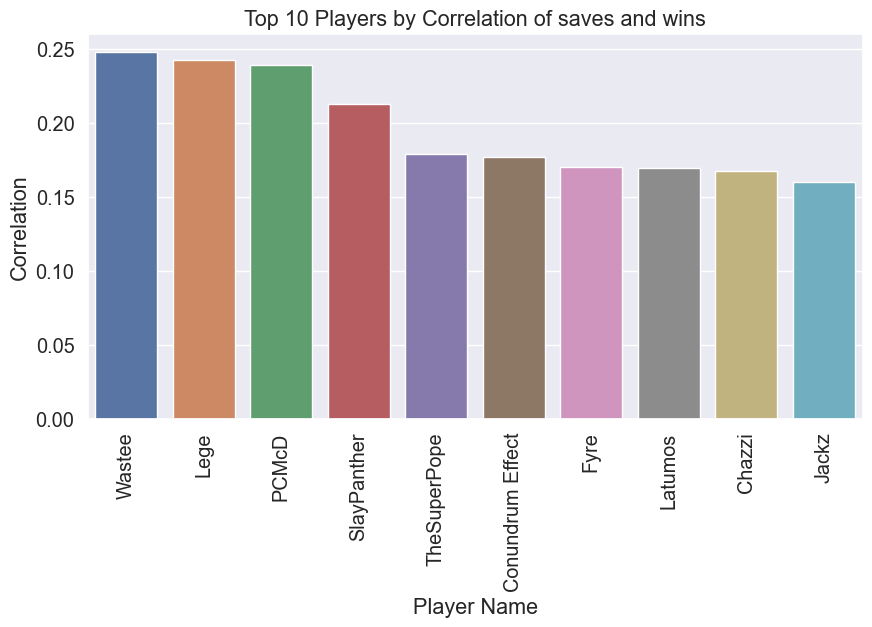

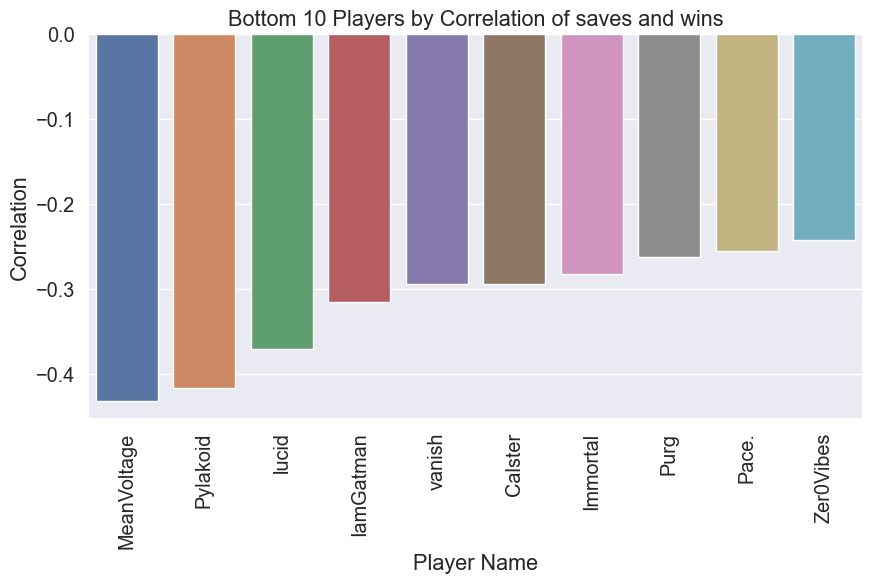

(                  player_id       player_name         0
 6  5f2c5c5c754b2f00087df2aa            Wastee  0.247606
 0  5ec9358f8c0dd900074685cf              Lege  0.242054
 3  600c9916eedc0d0008211473             PCMcD  0.238685
 2  5ec9358f8c0dd900074685d7       SlayPanther  0.212531
 8  605e0f92c376b10008e5d355      TheSuperPope  0.178860
 5  5ec9358f8c0dd900074685e3  Conundrum Effect  0.177001
 7  5f2c5d31bb182500085b6e08              Fyre  0.170336
 4  5f2c5145754b2f00087df27f           Latumos  0.169151
 9  5fdabe48c90cc90009196cc3            Chazzi  0.167515
 1  600c9a5b2c38930008d9cbfc             Jackz  0.159598,
                   player_id  player_name         0
 7  6144ed1571808a000992cb46  MeanVoltage -0.431067
 9  5f40118e5cfe2b0008d0abbf     Pylakoid -0.415761
 8  5f2c504c9682770008b3b01a        lucid -0.369886
 0  5ec9358f8c0dd900074685c8    IamGatman -0.314646
 2  6144ecec71808a000992cb43       vanish -0.294002
 3  5ec9358f8c0dd900074685ca      Calster -0.293343
 6  5ec9

In [120]:
create_correlation_charts('saves', 'wins')

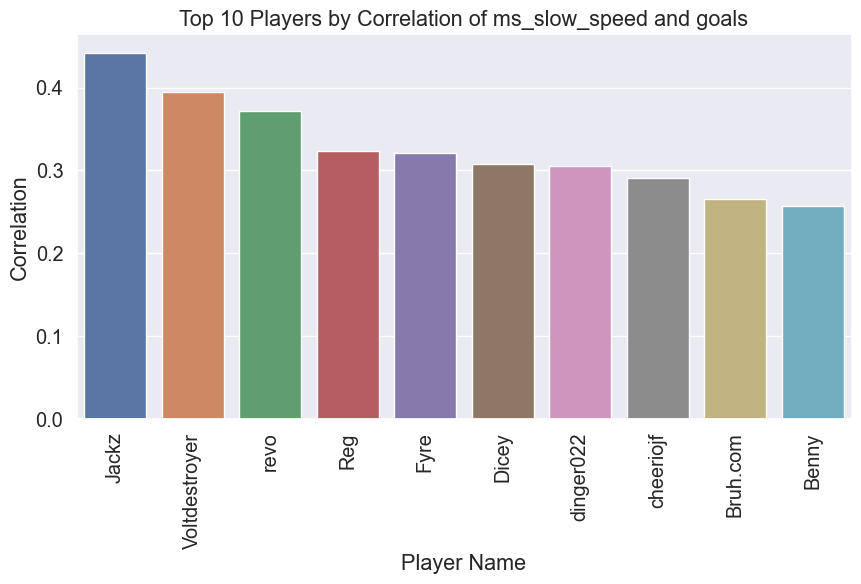

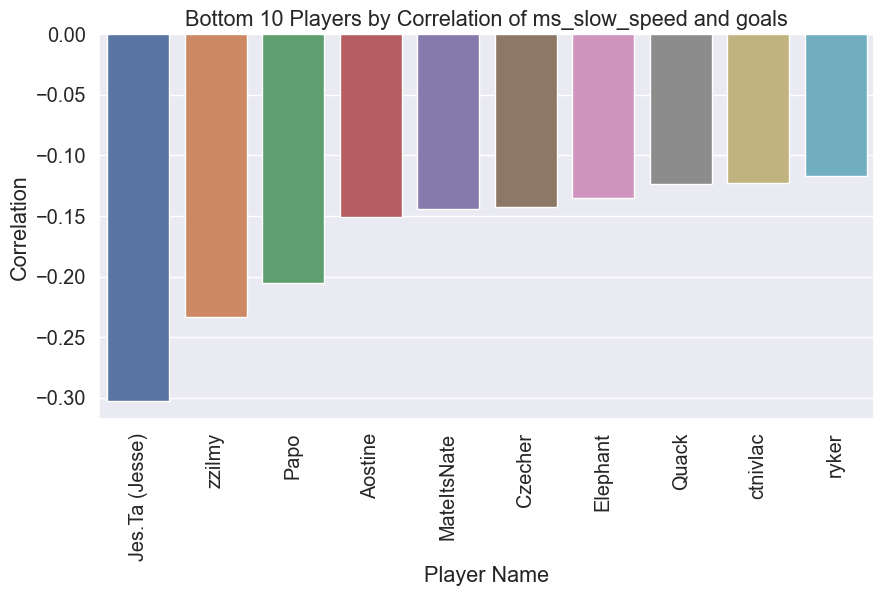

(                  player_id    player_name         0
 1  600c9a5b2c38930008d9cbfc          Jackz  0.442139
 2  610ef746fcc4b40009036428  Voltdestroyer  0.394425
 7  5f2c5c93bb182500085b6df6           revo  0.371711
 6  600c99a5eedc0d0008211486            Reg  0.322975
 5  5f2c5d31bb182500085b6e08           Fyre  0.321312
 3  5ec935928c0dd9000746860f          Dicey  0.308239
 0  600c9b08eedc0d00082114a3      dinger022  0.305790
 9  5ec9358f8c0dd900074685d2      cheeriojf  0.290472
 4  600c9b8deedc0d00082114ac       Bruh.com  0.266085
 8  600c993b2c38930008d9cbe2          Benny  0.257479,
                   player_id     player_name         0
 9  5f860cf8b607e300088048d1  Jes.Ta (Jesse) -0.302717
 5  60f4ba1eba91280008087542          zzilmy -0.233605
 3  60eb9ed77335fb00083ee143            Papo -0.205204
 2  5ec9358f8c0dd900074685da         Aostine -0.150906
 1  5f2c5c74bb182500085b6df4     MateItsNate -0.144260
 7  5f2c5c5b754b2f00087df2a8         Czecher -0.142343
 8  605ed23b0aea0f00

In [121]:
create_correlation_charts('ms_slow_speed', 'goals')

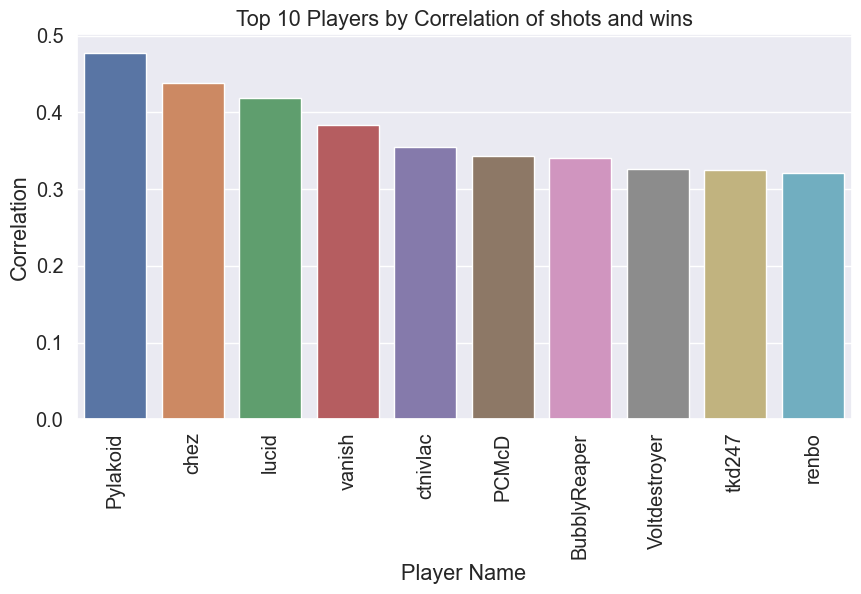

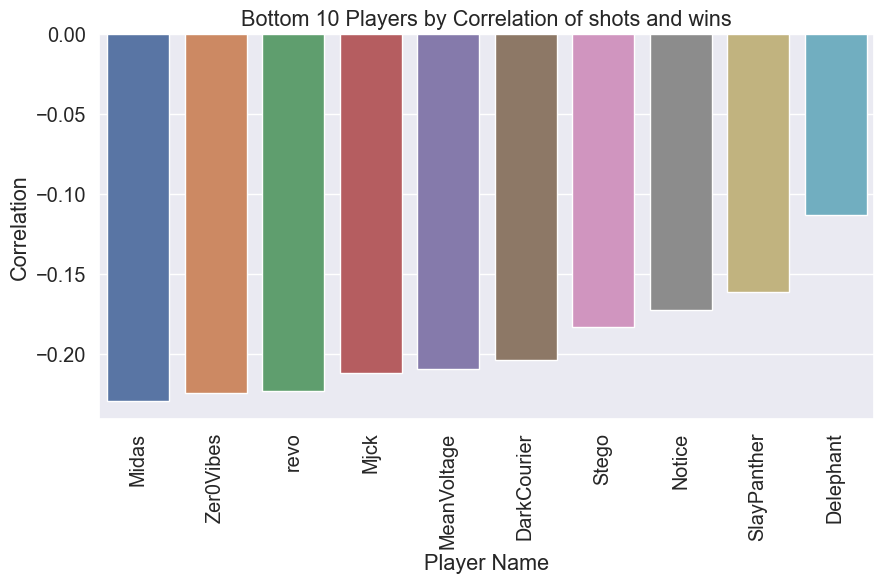

(                  player_id    player_name         0
 9  5f40118e5cfe2b0008d0abbf       Pylakoid  0.477829
 2  5ec9358f8c0dd900074685cb           chez  0.438026
 8  5f2c504c9682770008b3b01a          lucid  0.418407
 3  6144ecec71808a000992cb43         vanish  0.383209
 7  6205b4d81876ea0009d5b3de       ctnivlac  0.354945
 0  600c9916eedc0d0008211473          PCMcD  0.343137
 1  62226bcb85b38d0009b15b86   BubblyReaper  0.340666
 4  610ef746fcc4b40009036428  Voltdestroyer  0.326358
 6  5f2c5c47bb182500085b6de8         tkd247  0.325054
 5  60f4badcba91280008087558          renbo  0.321194,
                   player_id  player_name         0
 4  6144ecc571808a000992cb3e        Midas -0.229421
 2  5f2c5d0cbb182500085b6e04    Zer0Vibes -0.224725
 6  5f2c5c93bb182500085b6df6         revo -0.223301
 7  5f2c5c5bbb182500085b6ded         Mjck -0.212194
 9  6144ed1571808a000992cb46  MeanVoltage -0.209540
 8  600c9ae7eedc0d00082114a0  DarkCourier -0.203884
 1  5f2c5ce3754b2f00087df2b6        Stego

In [122]:
create_correlation_charts('shots', 'wins')

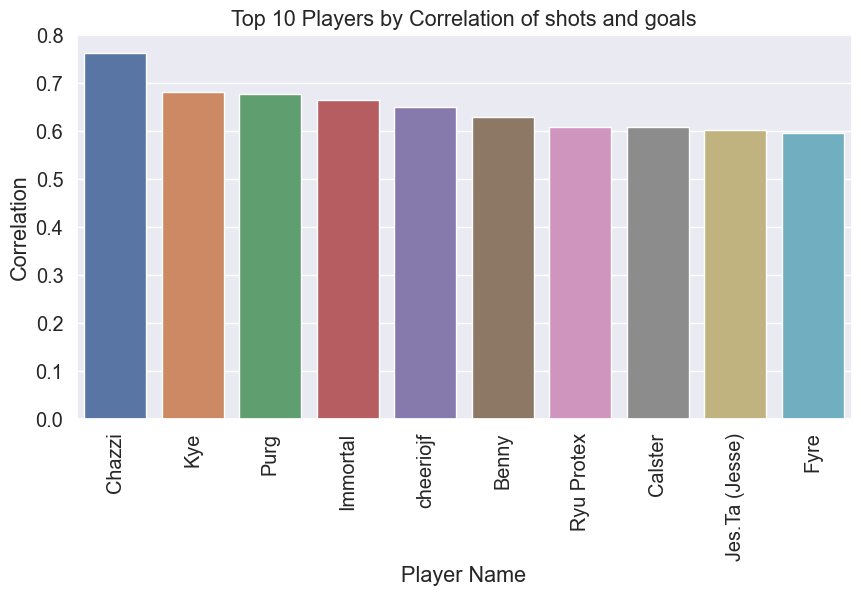

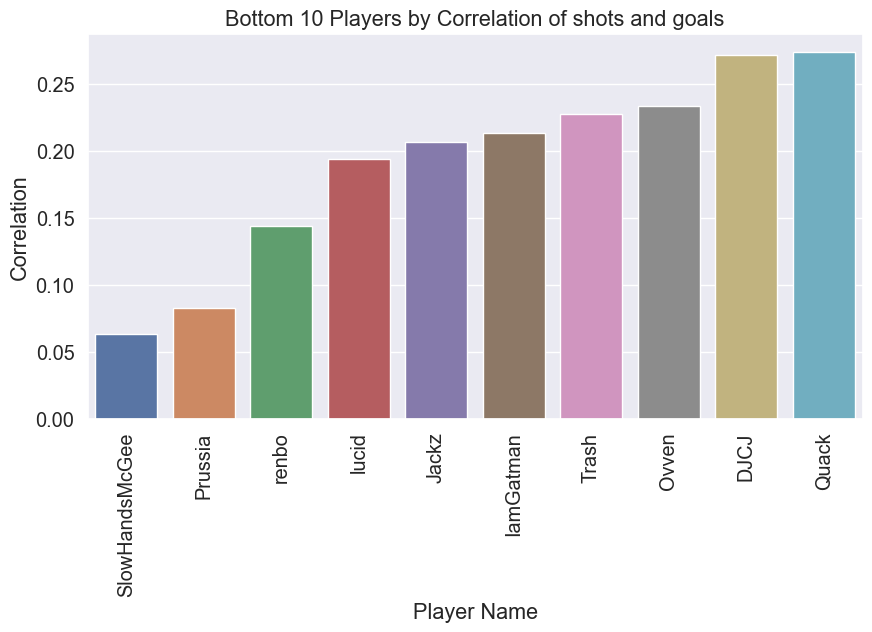

(                  player_id     player_name         0
 9  5fdabe48c90cc90009196cc3          Chazzi  0.763369
 0  60eb9d53ce9d6800082487c8             Kye  0.681857
 2  62081ff2660ef60009f505e5            Purg  0.677695
 5  5ec935928c0dd90007468626        Immortal  0.663838
 8  5ec9358f8c0dd900074685d2       cheeriojf  0.650892
 6  600c993b2c38930008d9cbe2           Benny  0.629570
 3  5ec9358f8c0dd900074685e5      Ryu Protex  0.609308
 1  5ec9358f8c0dd900074685ca         Calster  0.607427
 7  5f860cf8b607e300088048d1  Jes.Ta (Jesse)  0.602137
 4  5f2c5d31bb182500085b6e08            Fyre  0.596044,
                   player_id     player_name         0
 7  5fdaca27f0096e0008b2b712  SlowHandsMcGee  0.062988
 3  5ec9358f8c0dd900074685de         Prussia  0.082579
 5  60f4badcba91280008087558           renbo  0.144390
 9  5f2c504c9682770008b3b01a           lucid  0.193893
 1  600c9a5b2c38930008d9cbfc           Jackz  0.206531
 0  5ec9358f8c0dd900074685c8       IamGatman  0.213767
 4  6206e

In [123]:
create_correlation_charts('shots', 'goals')

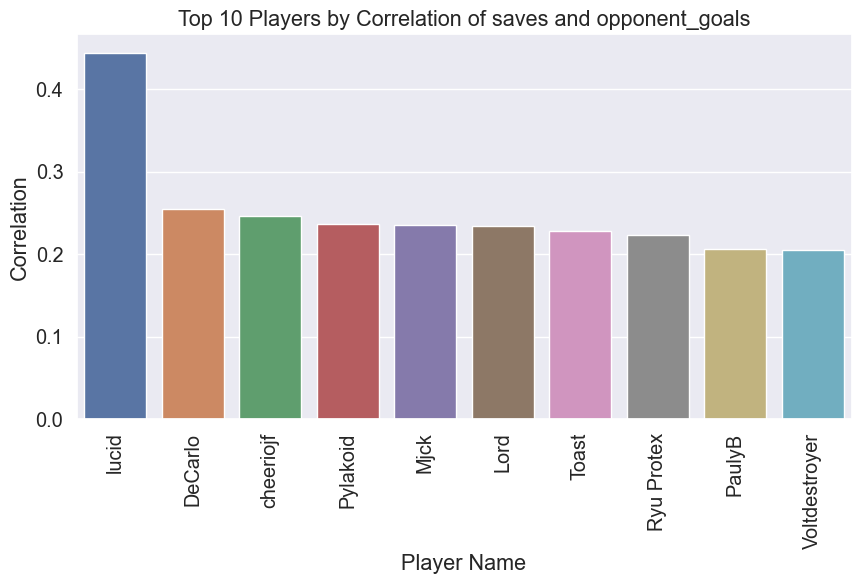

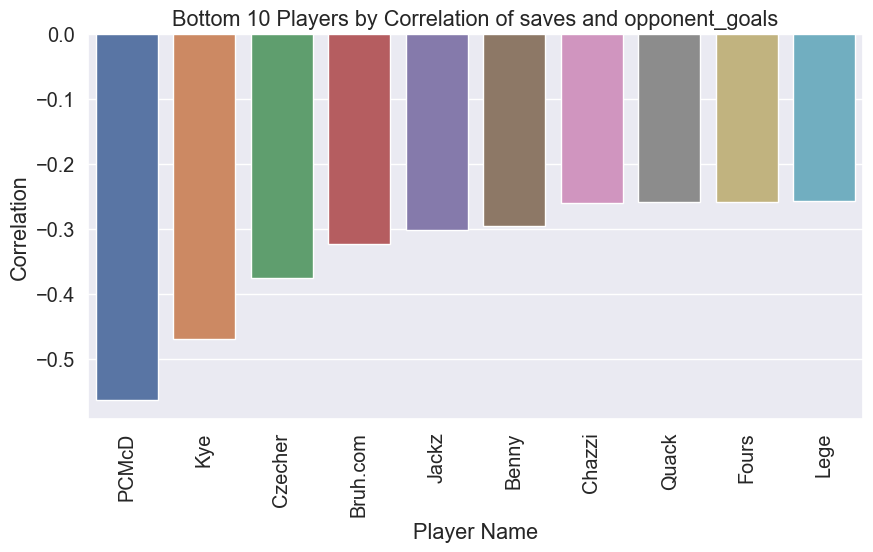

(                  player_id    player_name         0
 8  5f2c504c9682770008b3b01a          lucid  0.444431
 2  5ec935928c0dd9000746861a        DeCarlo  0.254657
 7  5ec9358f8c0dd900074685d2      cheeriojf  0.245949
 9  5f40118e5cfe2b0008d0abbf       Pylakoid  0.236748
 6  5f2c5c5bbb182500085b6ded           Mjck  0.235891
 1  60eb9eca7335fb00083ee13c           Lord  0.234833
 4  601265ddeba52b000847388d          Toast  0.228573
 3  5ec9358f8c0dd900074685e5     Ryu Protex  0.223201
 5  5fdabf7bcf298e0008e91633         PaulyB  0.206385
 0  610ef746fcc4b40009036428  Voltdestroyer  0.205675,
                   player_id player_name         0
 3  600c9916eedc0d0008211473       PCMcD -0.563141
 2  60eb9d53ce9d6800082487c8         Kye -0.469424
 8  5f2c5c5b754b2f00087df2a8     Czecher -0.374968
 5  600c9b8deedc0d00082114ac    Bruh.com -0.322853
 1  600c9a5b2c38930008d9cbfc       Jackz -0.302033
 6  600c993b2c38930008d9cbe2       Benny -0.295826
 9  5fdabe48c90cc90009196cc3      Chazzi -0.2597

In [124]:
create_correlation_charts('saves', 'opponent_goals')

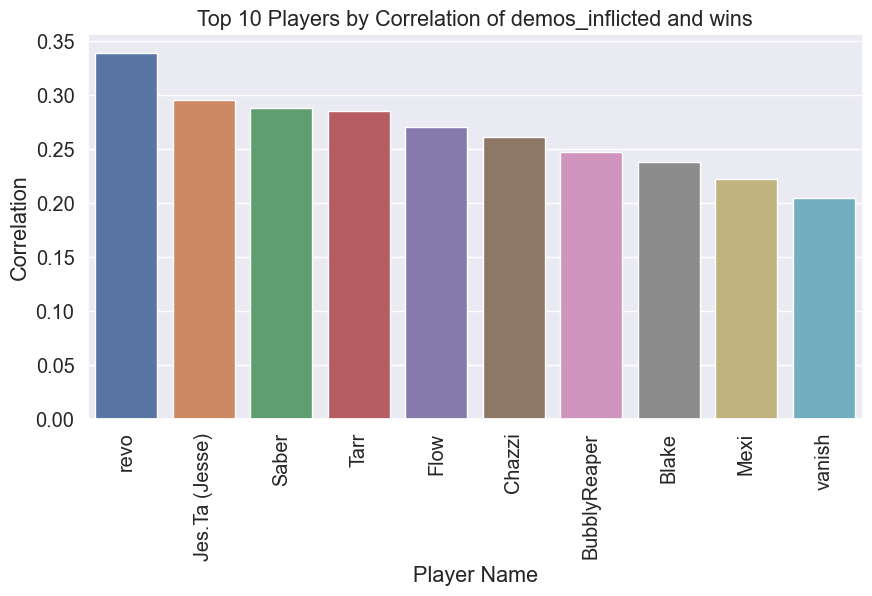

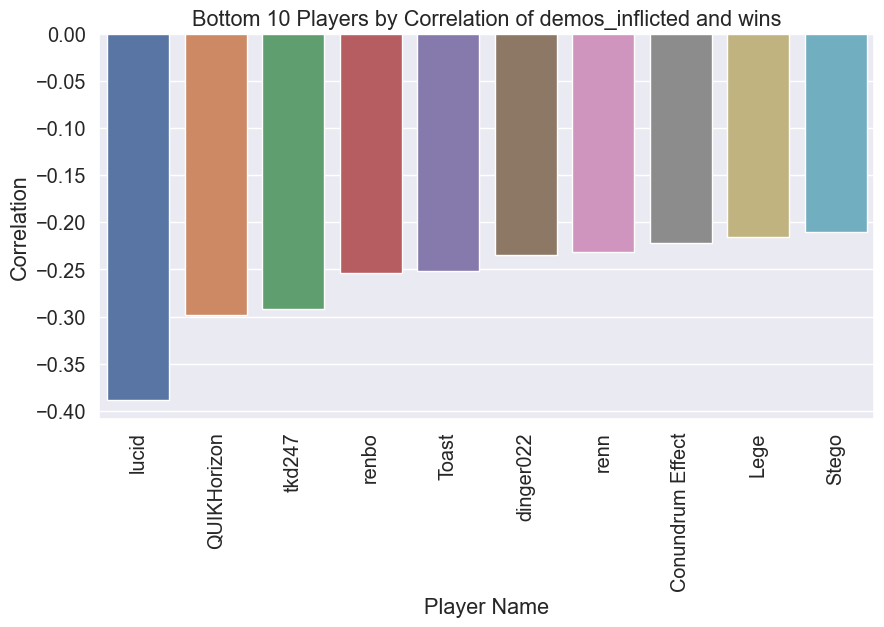

(                  player_id     player_name         0
 6  5f2c5c93bb182500085b6df6            revo  0.339502
 8  5f860cf8b607e300088048d1  Jes.Ta (Jesse)  0.295786
 4  600c99a5eedc0d0008211484           Saber  0.287879
 5  5ec935928c0dd9000746861c            Tarr  0.285505
 3  600c994b2c38930008d9cbe6            Flow  0.270659
 9  5fdabe48c90cc90009196cc3          Chazzi  0.261247
 1  62226bcb85b38d0009b15b86    BubblyReaper  0.247318
 7  600c98fd2c38930008d9cbda           Blake  0.238124
 0  5ec9358f8c0dd900074685e2            Mexi  0.222808
 2  6144ecec71808a000992cb43          vanish  0.204562,
                   player_id       player_name         0
 9  5f2c504c9682770008b3b01a             lucid -0.388889
 7  5ec935928c0dd90007468612       QUIKHorizon -0.298435
 5  5f2c5c47bb182500085b6de8            tkd247 -0.291841
 3  60f4badcba91280008087558             renbo -0.253536
 8  601265ddeba52b000847388d             Toast -0.251453
 1  600c9b08eedc0d00082114a3         dinger022 -0.23

In [125]:
create_correlation_charts('demos_inflicted', 'wins')

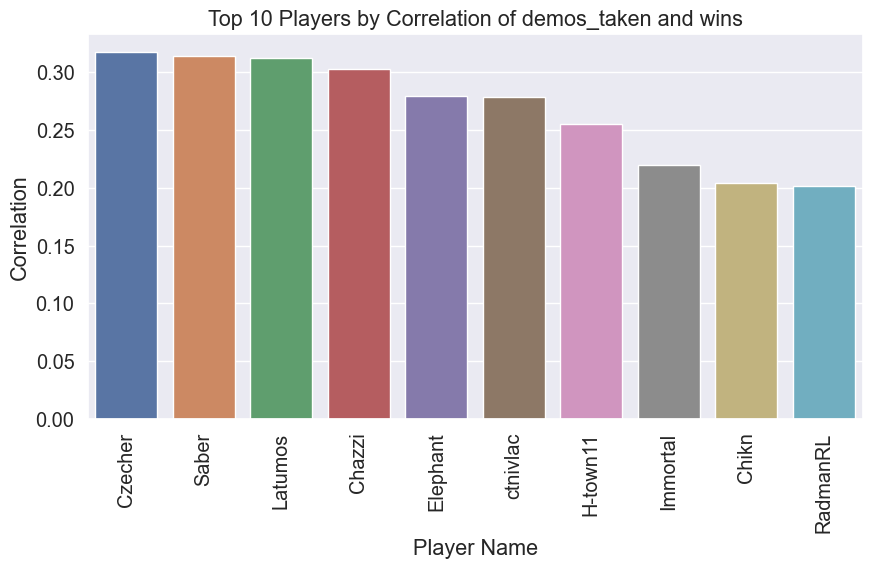

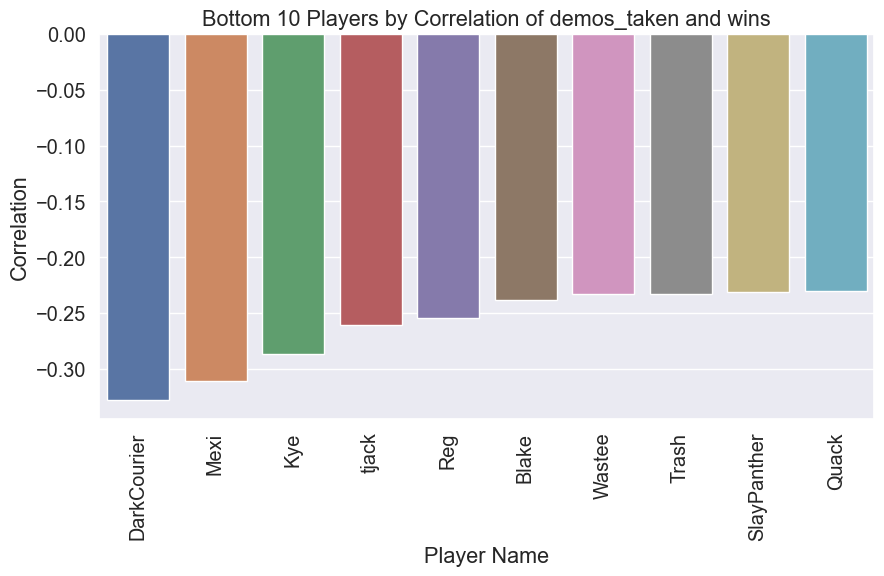

(                  player_id player_name         0
 6  5f2c5c5b754b2f00087df2a8     Czecher  0.317236
 3  600c99a5eedc0d0008211484       Saber  0.313829
 0  5f2c5145754b2f00087df27f     Latumos  0.311811
 9  5fdabe48c90cc90009196cc3      Chazzi  0.302445
 7  605ed23b0aea0f000890a8ca    Elephant  0.279671
 2  6205b4d81876ea0009d5b3de    ctnivlac  0.278101
 5  600c9ad02c38930008d9cc09    H-town11  0.254899
 4  5ec935928c0dd90007468626    Immortal  0.219394
 1  5f2b812976113c0008fcee73       Chikn  0.204476
 8  5ec935928c0dd90007468614    RadmanRL  0.201199,
                   player_id  player_name         0
 7  600c9ae7eedc0d00082114a0  DarkCourier -0.328000
 3  5ec9358f8c0dd900074685e2         Mexi -0.311041
 2  60eb9d53ce9d6800082487c8          Kye -0.286237
 1  5ec9358f8c0dd900074685d3        tjack -0.260129
 6  600c99a5eedc0d0008211486          Reg -0.254140
 8  600c98fd2c38930008d9cbda        Blake -0.238562
 5  5f2c5c5c754b2f00087df2aa       Wastee -0.233093
 4  6206ea234524150009

In [126]:
create_correlation_charts('demos_taken', 'wins')

## Standard Deviations

In order to determine which columns might be best at predicting whether a player or combination of players will win or lose a game, I'd like to understand which columns have the lowest standard deviation. From there, I'll use that in model training to see if we can get a relatively reliable model.

For the sake of exploring the data, I'll also investigate which columns have the highest standard deviation.

In [127]:
# Calculate the standard deviation for each column for each player
object_columns = list(data.dtypes[data.dtypes == 'object'].index)
no_std_diff_cols = object_columns + ['is_sub_for_team', 'mvps']

# ignore any rows for overtimes
player_stds_df = data.drop([c for c in no_std_diff_cols if 'player_id' not in c], axis=1)

# drop columns that 
player_stds_df = player_stds_df.drop([
    'match_id_win', 'wins', 'shots', 'assists', 'goals', 'saves', 'season_name', 'game_number'
    ], axis=1)
object_columns = player_stds_df.dtypes[data.dtypes == 'object'].index
player_stds = player_stds_df.groupby('player_id').std()

# Find the top 10 columns with the highest and lowest standard deviation for each player
player_max_std = player_stds.apply(lambda x: x.nlargest(10).index.tolist(), axis=1)
player_min_std = player_stds.apply(lambda x: x.nsmallest(10).index.tolist(), axis=1)

# Calculate the standard deviation for each column for the whole dataset
player_stds_df = player_stds_df.drop(columns=['player_id'], axis=1)
total_std = player_stds_df.std()

# Find the top 10 columns with the highest and lowest standard deviation in the dataset
total_max_std = total_std.nlargest(10).index.tolist()
total_min_std = total_std.nsmallest(10).index.tolist()

print("Columns with highest standard deviation per player:")
print(player_max_std)
print("\nColumns with lowest standard deviation per player:")
print(player_min_std)
print("\nColumns with highest standard deviation in total dataset:", total_max_std)
print("\nColumns with lowest standard deviation in total dataset:", total_min_std)

Columns with highest standard deviation per player:
player_id
5ec9358f8c0dd900074685c7    [total_distance, ms_played, ms_defensive_half,...
5ec9358f8c0dd900074685c8    [total_distance, ms_played, ms_behind_ball, ms...
5ec9358f8c0dd900074685c9    [total_distance, ms_played, ms_behind_ball, ms...
5ec9358f8c0dd900074685ca    [total_distance, ms_played, ms_behind_ball, ms...
5ec9358f8c0dd900074685cb    [total_distance, ms_played, ms_behind_ball, ms...
                                                  ...                        
643e0154b0bbb6000889bea6    [game_date, ms_played, shots_against, score, a...
643e0154b0bbb6000889bea8    [game_date, ms_played, shots_against, score, a...
643e039cb0bbb6000889bed3    [total_distance, ms_played, ms_defensive_half,...
643e0bd09ad2c40008d7eccf    [game_date, ms_played, shots_against, score, a...
6469648817cc4400089d215f    [game_date, ms_played, shots_against, score, a...
Length: 293, dtype: object

Columns with lowest standard deviation per player:
p

In [128]:
# this is interesting but creates WAY too many charts


# Loop through each numerical column
# for col in data.select_dtypes(include=['int64', 'float64']).columns:
    
#     # Plot distribution
#     plt.figure(figsize=(14,6))
    
#     # Subplot 1: Distribution plot
#     plt.subplot(1, 2, 1)
#     sns.histplot(data[col], kde=True)
#     plt.title(f'Distribution of {col}')
    
#     # Subplot 2: Box plot
#     plt.subplot(1, 2, 2)
#     sns.boxplot(x=data[col])
#     plt.title(f'Box Plot of {col}')
    
#     plt.show()